In [69]:
!pip install qiskit
!pip install tqdm
!pip install torchviz
!pip install qiskit-aer
!pip install qiskit_algorithms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

import qiskit
from qiskit import Aer, QuantumRegister, QuantumCircuit as QiskitQuantumCircuit, ClassicalRegister, transpile, assemble
from qiskit.circuit import Parameter, ParameterVector
from qiskit.visualization import *


from scipy.optimize import minimize
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image  # A library for image processing
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
# %matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from PIL import Image  # A library for image processing
%matplotlib inline

In [1]:
QC_outputs = ['00', '01', '10', '11']

In [37]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit.
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta_0 = qiskit.circuit.Parameter('theta0')
        self.theta_1 = qiskit.circuit.Parameter('theta1')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        
        self._circuit.ry(self.theta_0, 0)
        self._circuit.ry(self.theta_1, 1)
        for i in range(n_qubits - 1):
            self._circuit.cnot(i, i + 1)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        # Convert to floats if necessary
        thetas = [float(theta.real) for theta in thetas]
        
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots, parameter_binds=[
            {self.theta_0: thetas[0],
             self.theta_1: thetas[1]}
        ])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        states = np.array(list(result.keys())).astype(float)
        expects = np.zeros(4)
        resp = np.zeros(1)
        for k in range(4):
            key = QC_outputs[k]
            expe = result.get(key, 0)
            perc = expe / self.shots

            expects[k] = perc
            resp[0] += float(key) * perc
        return resp

In [9]:
#Going to test out the quantum circuit.
sim = qiskit.Aer.get_backend('qasm_simulator')

test_circuit = QuantumCircuit(2, sim, 100000)

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)


In [10]:
#Heck yeah it works! It outputs the distributions of the outputs
test_circuit.run([1,2]), test_circuit._circuit.draw()   

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


(array([2.09089]),
         ┌───┐ ░ ┌────────────┐      ░ ┌─┐   
    q_0: ┤ H ├─░─┤ Ry(theta0) ├──■───░─┤M├───
         ├───┤ ░ ├────────────┤┌─┴─┐ ░ └╥┘┌─┐
    q_1: ┤ H ├─░─┤ Ry(theta1) ├┤ X ├─░──╫─┤M├
         └───┘ ░ └────────────┘└───┘ ░  ║ └╥┘
 meas: 2/═══════════════════════════════╩══╩═
                                        0  1 )

In [38]:
def to_numbers(input):
    parameter = []

    #A very scrapy but functional way of loading the parameters in this format
    for x in input:
        for y in x:
            parameter.append(float(y.real))
    return parameter

In [39]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Convert input to float and ensure no complex values
        input_floats = [float(x) for x in to_numbers(input)]
        expectation_z = ctx.quantum_circuit.run(input_floats)
        #expectation_z = ctx.quantum_circuit.run(to_numbers(input))

        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = list(input)[0]

        gradients = torch.Tensor()

        for i in range(2):
            shift_right = np.array(input_list.detach().clone())
            shift_left = np.array(input_list.detach().clone())

            shift_right[i] = float(shift_right[i] + ctx.shift)
            shift_left[i] = float(shift_left[i] - ctx.shift)

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        gradients = gradients.T
        resp = gradients.float() * grad_output.float().T
        return resp, None, None


In [15]:
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift, n_qubits):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(n_qubits, backend, shots)
        self.quantum_circuit._circuit.draw()
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


In [16]:
class Net(nn.Module):
    def __init__(self, n_qubits):
        super(Net, self).__init__()
        # Definiendo todas las capas clásicas
        self.classical = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d()
        )
        
        # Definiendo la parte intermedia
        self.middel = nn.Sequential(
            nn.Linear(20 * 5 * 5, 500),  # Ajustar el tamaño del tensor adecuadamente
            nn.ReLU(),
            nn.Linear(500, n_qubits)
        )
        
        # Definiendo la parte cuántica
        self.quantum = Hybrid(Aer.get_backend('qasm_simulator'), 1000, np.pi / 2, n_qubits=n_qubits)
        
        # Definiendo la parte final de las capas clásicas
        self.end = nn.Sequential(
            nn.Linear(8, 5),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.classical(x)
        x = x.view(x.size(0), -1)  # Ajuste para el tamaño del batch
        
        # Pasar a través de la parte intermedia
        x = self.middel(x)
        
        # Pasar a través de la parte cuántica
        x = self.quantum(x)
        
        # Pasar a través de la parte final clásica
       # x = self.end(x.float())
        #x = x.view(1, -1)
        # Retornar la salida final
        return torch.cat((x, 1 - x), -1)
    
#learning sheduller, batch normalization, profundidad, LICyRELU

In [17]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust the image size as needed
    transforms.ToTensor()
])

# Load your custom dataset
custom_dataset = datasets.ImageFolder(root='C:/Users/Sergio/Documents/archive-20240617T011328Z-001/archive/Training', transform=transform)

# Extract labels and filter the dataset
labels = custom_dataset.targets
labels = np.array(labels)

# Specify the number of datapoints per class
n = 100

# Select indices for the two classes
idx_glioma = np.where(labels == 0)[0][:n]
idx_notumor = np.where(labels == 1)[0][:n]

# Concatenate the selected indices
selected_indices = np.concatenate((idx_glioma, idx_notumor))

# Update the dataset with the filtered labels and samples
custom_dataset.targets = labels[selected_indices]
custom_dataset.samples = [custom_dataset.samples[i] for i in selected_indices]

# Create a DataLoader for your dataset
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=1, shuffle=True)

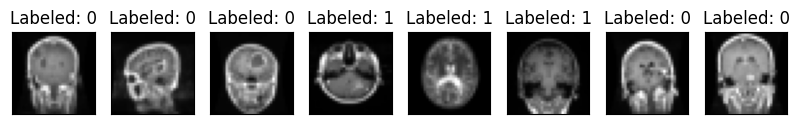

In [18]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

In [19]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust the image size as needed
    transforms.ToTensor()
])

# Load your custom test dataset
custom_test_dataset = datasets.ImageFolder(root='C:/Users/Sergio/Documents/archive-20240617T011328Z-001/archive/Testing', transform=transform)

# Extract labels and filter the test dataset
labels = custom_test_dataset.targets
labels = np.array(labels)

# Specify the number of datapoints per class
n = 100

# Select indices for the two classes
idx_glioma = np.where(labels == 0)[0][:n]
idx_notumor = np.where(labels == 1)[0][:n]

# Concatenate the selected indices
selected_indices = np.concatenate((idx_glioma, idx_notumor))

# Update the test dataset with the filtered labels and samples
custom_test_dataset.targets = labels[selected_indices]
custom_test_dataset.samples = [custom_test_dataset.samples[i] for i in selected_indices]

# Create a DataLoader for your test dataset
test_loader = torch.utils.data.DataLoader(custom_test_dataset, batch_size=1, shuffle=True)

In [82]:
from qiskit_algorithms.optimizers import COBYLA
'''
def fitness_cost(parameters):
    # Refefencia a tu circuito cuantico
    qc = QuantumCircuit(3) # Llamar de algun lugar
    qc.set_parameters(parameters) #Buscar como se setean los parametros
    
    backend.run()
    job = backend.run().jobs()
    result = job.result()
    score = # Encontrar el valor esperado 
            # freq = {'01111':4, '11010':6}
            # acum = np.zeros(num_qubits)
            # sz = 0
            # for key,val in freq.items():
            #  sz += val
            #  for i,bin in enumerate(key):
            #    acum[i] += to_int(bin)
            # acum /= sz
            #
            # Verificar que tan bien le fue:
            # si el modelo fue pensado en encontrar la energia mímima
            #   se retorna el valor esperado
            # Caso contrario, me parece que, junto a parametros, se debe
            # colocar el valor deseado para comparlo con el esperado
    return score
 
    optimizer = COBYLA(maxiter=100)
    model_ = optimizer.minimize(fun=fitness_cost, x0=[0]*3 )
    print(model_)
    print("Best values:", model_.x)
    exit()
    '''

'\ndef fitness_cost(parameters):\n    # Refefencia a tu circuito cuantico\n    qc = QuantumCircuit(3) # Llamar de algun lugar\n    qc.set_parameters(parameters) #Buscar como se setean los parametros\n    \n    backend.run()\n    job = backend.run().jobs()\n    result = job.result()\n    score = # Encontrar el valor esperado \n            # freq = {\'01111\':4, \'11010\':6}\n            # acum = np.zeros(num_qubits)\n            # sz = 0\n            # for key,val in freq.items():\n            #  sz += val\n            #  for i,bin in enumerate(key):\n            #    acum[i] += to_int(bin)\n            # acum /= sz\n            #\n            # Verificar que tan bien le fue:\n            # si el modelo fue pensado en encontrar la energia mímima\n            #   se retorna el valor esperado\n            # Caso contrario, me parece que, junto a parametros, se debe\n            # colocar el valor deseado para comparlo con el esperado\n    return score\n \n    optimizer = COBYLA(maxiter=10

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\1901301252.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:2

Epoch [1/5]	Training [20%]	Loss: 2.1671
Epoch [1/5]	Validation	Loss: 0.6929	Validation Accuracy: 71.5%
Epoch [2/5]	Training [40%]	Loss: 1.2072
Epoch [2/5]	Validation	Loss: 0.8411	Validation Accuracy: 68.0%
Epoch [3/5]	Training [60%]	Loss: 0.9770
Epoch [3/5]	Validation	Loss: 1.0008	Validation Accuracy: 64.5%
Epoch [4/5]	Training [80%]	Loss: 1.1185
Epoch [4/5]	Validation	Loss: 0.6544	Validation Accuracy: 70.0%
Epoch [5/5]	Training [100%]	Loss: 0.9305
Epoch [5/5]	Validation	Loss: 0.6434	Validation Accuracy: 72.5%
Rendimiento del test data:
	Loss: 0.6434
	Accuracy: 72.5%
	precision: 82.3%
	recall: 72.5%
	f_score: 70.3%
(0.8225806451612903, 0.725, 0.7025016903313049, None)

Confusion Matrix:
[[100   0]
 [ 55  45]]


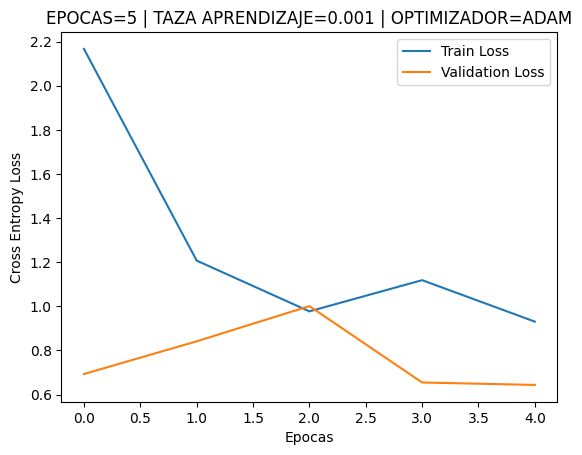

In [20]:
model = Net(n_qubits = 2)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training

    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        #minimize()
        
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))
    

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Rendimiento del test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 2.9554
Epoch [1/5]	Validation	Loss: 1.5085	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.9149
Epoch [2/5]	Validation	Loss: 1.0115	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.8205
Epoch [3/5]	Validation	Loss: 1.0420	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 0.8299
Epoch [4/5]	Validation	Loss: 0.8146	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 0.8520
Epoch [5/5]	Validation	Loss: 0.9421	Validation Accuracy: 50.0%
Rendimiento del test data:
	Loss: 0.9421
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


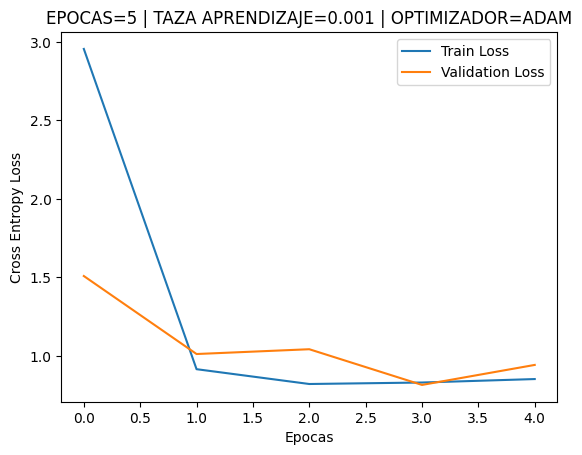

In [21]:
model = Net(n_qubits = 2)

optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training

    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        #minimize()
        
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))
    

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Rendimiento del test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


In [22]:
num_qubits = 2

**Ahora entrenemos la red**

We can specify any PyTorch optimiser (here we use the Adam optimiser), learning rate and cost/loss function in order to train over multiple epochs. In this instance, we use  a learning rate of 0.001 and the negative log-likelihood loss function.
We then plot the training graph. We do this for 5, 10, 20, 30 epochs

--------------------------------EMPEZAMOSS----------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 3.2062
Epoch [1/5]	Validation	Loss: 4.7478	Validation Accuracy: 49.5%
Epoch [2/5]	Training [40%]	Loss: 5.2288
Epoch [2/5]	Validation	Loss: 4.9831	Validation Accuracy: 50.5%
Epoch [3/5]	Training [60%]	Loss: 4.7347
Epoch [3/5]	Validation	Loss: 5.0574	Validation Accuracy: 51.0%
Epoch [4/5]	Training [80%]	Loss: 5.0246
Epoch [4/5]	Validation	Loss: 4.7475	Validation Accuracy: 48.5%
Epoch [5/5]	Training [100%]	Loss: 5.4844
Epoch [5/5]	Validation	Loss: 4.7832	Validation Accuracy: 52.0%
Performance on the test data:
	Loss: 4.7832
	Accuracy: 52.0%
	precision: 60.5%
	recall: 52.0%
	f_score: 39.8%
(0.6052631578947368, 0.52, 0.3981191222570533, None)

Confusion Matrix:
[[97  3]
 [93  7]]


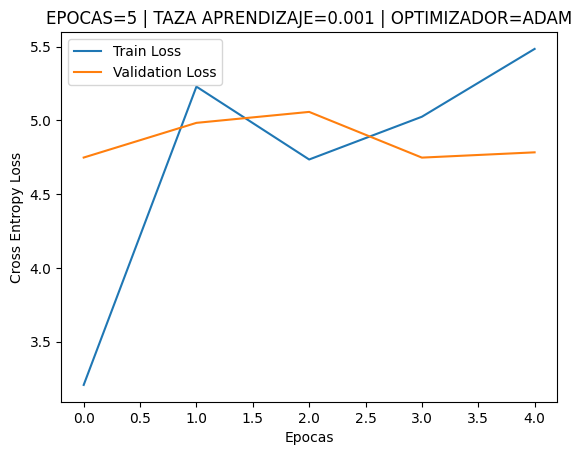

In [23]:
model = Net(n_qubits = 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


EPOCHS=10, LEARNING RATE=0.001, OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 4.3122
Epoch [1/10]	Validation	Loss: 5.8614	Validation Accuracy: 49.5%
Epoch [2/10]	Training [20%]	Loss: 5.0691
Epoch [2/10]	Validation	Loss: 5.5661	Validation Accuracy: 49.5%
Epoch [3/10]	Training [30%]	Loss: 5.0531
Epoch [3/10]	Validation	Loss: 6.1557	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 5.1163
Epoch [4/10]	Validation	Loss: 5.0160	Validation Accuracy: 48.0%
Epoch [5/10]	Training [50%]	Loss: 4.6555
Epoch [5/10]	Validation	Loss: 5.2345	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 4.7606
Epoch [6/10]	Validation	Loss: 6.8134	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 5.1876
Epoch [7/10]	Validation	Loss: 4.9603	Validation Accuracy: 50.5%
Epoch [8/10]	Training [80%]	Loss: 5.0544
Epoch [8/10]	Validation	Loss: 5.3153	Validation Accuracy: 52.5%
Epoch [9/10]	Training [90%]	Loss: 4.9737
Epoch [9/10]	Validation	Loss: 5.5452	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 3.7452
Epoch [10/10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


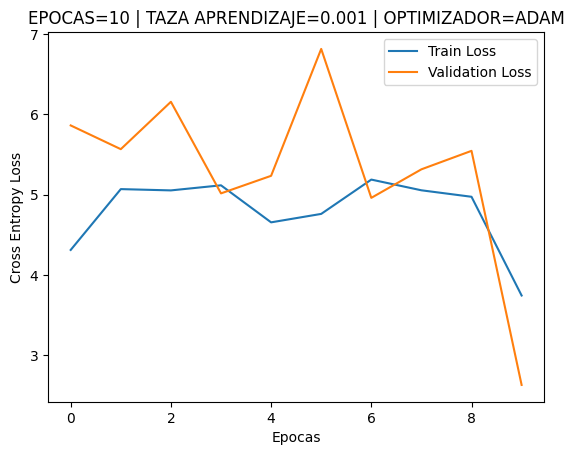

In [24]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 2.5987
Epoch [1/15]	Validation	Loss: 2.5266	Validation Accuracy: 54.0%
Epoch [2/15]	Training [13%]	Loss: 4.9687
Epoch [2/15]	Validation	Loss: 5.0268	Validation Accuracy: 49.5%
Epoch [3/15]	Training [20%]	Loss: 4.8575
Epoch [3/15]	Validation	Loss: 5.1512	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 4.9137
Epoch [4/15]	Validation	Loss: 4.5674	Validation Accuracy: 50.5%
Epoch [5/15]	Training [33%]	Loss: 4.8110
Epoch [5/15]	Validation	Loss: 5.0122	Validation Accuracy: 50.5%
Epoch [6/15]	Training [40%]	Loss: 5.0133
Epoch [6/15]	Validation	Loss: 4.5445	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 4.4304
Epoch [7/15]	Validation	Loss: 4.9831	Validation Accuracy: 51.5%
Epoch [8/15]	Training [53%]	Loss: 4.8217
Epoch [8/15]	Validation	Loss: 2.1767	Validation Accuracy: 52.0%
Epoch [9/15]	Training [60%]	Loss: 4.5079
Epoch [9/15]	Validation	Loss: 5.2441	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 4.8079
Epoch [10/15]	

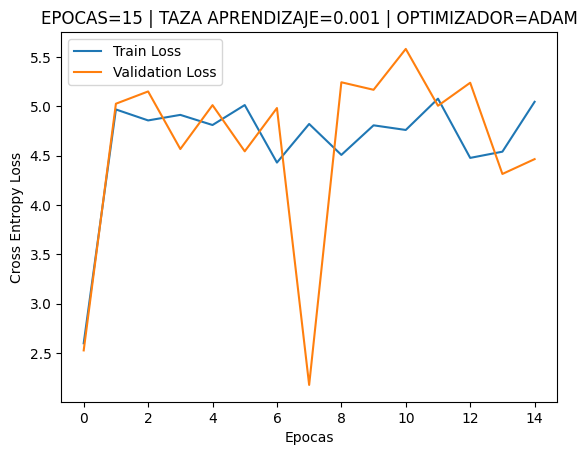

In [25]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 4.2869
Epoch [1/20]	Validation	Loss: 4.4313	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 5.1334
Epoch [2/20]	Validation	Loss: 5.3448	Validation Accuracy: 51.0%
Epoch [3/20]	Training [15%]	Loss: 5.0697
Epoch [3/20]	Validation	Loss: 4.8549	Validation Accuracy: 49.0%
Epoch [4/20]	Training [20%]	Loss: 5.4141
Epoch [4/20]	Validation	Loss: 5.0448	Validation Accuracy: 48.0%
Epoch [5/20]	Training [25%]	Loss: 4.4323
Epoch [5/20]	Validation	Loss: 5.3916	Validation Accuracy: 51.0%
Epoch [6/20]	Training [30%]	Loss: 4.4848
Epoch [6/20]	Validation	Loss: 5.0898	Validation Accuracy: 49.5%
Epoch [7/20]	Training [35%]	Loss: 3.8393
Epoch [7/20]	Validation	Loss: 4.7936	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 3.9830
Epoch [8/20]	Validation	Loss: 5.3850	Validation Accuracy: 49.5%
Epoch [9/20]	Training [45%]	Loss: 4.3649
Epoch [9/20]	Validation	Loss: 4.7551	Validation Accuracy: 49.5%
Epoch [10/20]	Training [50%]	Loss: 4.1994
Epoch [10/20]	

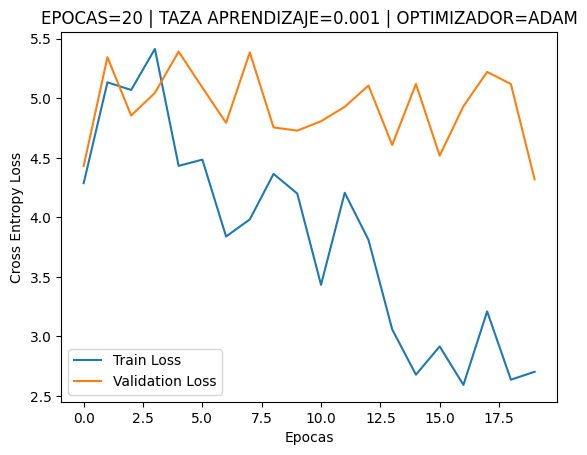

In [26]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=30 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/30]	Training [3%]	Loss: 2.7769
Epoch [1/30]	Validation	Loss: 1.7207	Validation Accuracy: 52.5%
Epoch [2/30]	Training [7%]	Loss: 1.3218
Epoch [2/30]	Validation	Loss: 1.1897	Validation Accuracy: 51.5%
Epoch [3/30]	Training [10%]	Loss: 1.1547
Epoch [3/30]	Validation	Loss: 1.4478	Validation Accuracy: 50.0%
Epoch [4/30]	Training [13%]	Loss: 0.6384
Epoch [4/30]	Validation	Loss: 1.0741	Validation Accuracy: 50.0%
Epoch [5/30]	Training [17%]	Loss: 0.5995
Epoch [5/30]	Validation	Loss: 0.7142	Validation Accuracy: 52.5%
Epoch [6/30]	Training [20%]	Loss: 0.4896
Epoch [6/30]	Validation	Loss: 0.6843	Validation Accuracy: 56.0%
Epoch [7/30]	Training [23%]	Loss: 0.4792
Epoch [7/30]	Validation	Loss: 0.5865	Validation Accuracy: 70.0%
Epoch [8/30]	Training [27%]	Loss: 0.4273
Epoch [8/30]	Validation	Loss: 1.0401	Validation Accuracy: 55.0%
Epoch [9/30]	Training [30%]	Loss: 0.4393
Epoch [9/30]	Validation	Loss: 0.7230	Validation Accuracy: 59.0%
Epoch [10/30]	Training [33%]	Loss: 0.4367
Epoch [10/30]	V

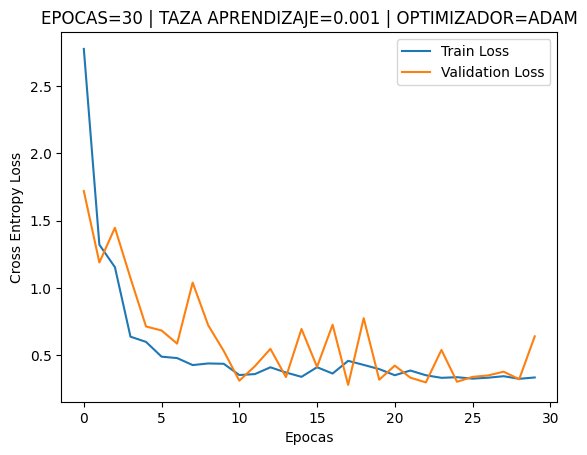

In [27]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 30
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=30 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 *******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 3.1383
Epoch [1/5]	Validation	Loss: 4.7953	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 3.9529
Epoch [2/5]	Validation	Loss: 5.4651	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 3.3889
Epoch [3/5]	Validation	Loss: 3.1479	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 1.2790
Epoch [4/5]	Validation	Loss: 2.4800	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 1.1367
Epoch [5/5]	Validation	Loss: 4.9448	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 4.9448
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


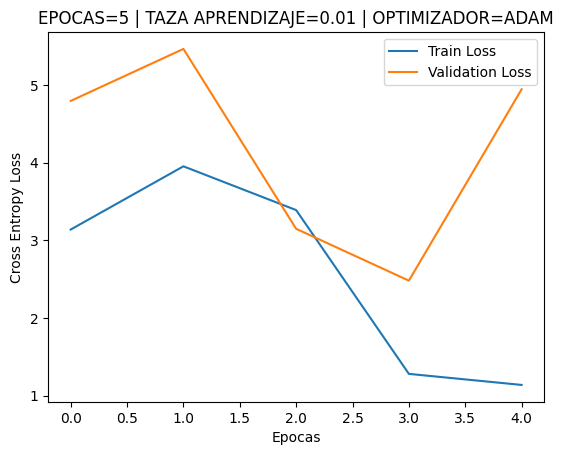

In [28]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 4.5816
Epoch [1/10]	Validation	Loss: 5.2943	Validation Accuracy: 47.0%
Epoch [2/10]	Training [20%]	Loss: 3.2147
Epoch [2/10]	Validation	Loss: 3.0081	Validation Accuracy: 42.0%
Epoch [3/10]	Training [30%]	Loss: 2.5824
Epoch [3/10]	Validation	Loss: 3.3107	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 1.8920
Epoch [4/10]	Validation	Loss: 4.0327	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 1.9449
Epoch [5/10]	Validation	Loss: 1.1876	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 0.9925
Epoch [6/10]	Validation	Loss: 6.3956	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 1.4196
Epoch [7/10]	Validation	Loss: 0.8552	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 0.8499
Epoch [8/10]	Validation	Loss: 0.8176	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 0.8153
Epoch [9/10]	Validation	Loss: 0.8224	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 0.8223
Epoch [10/10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


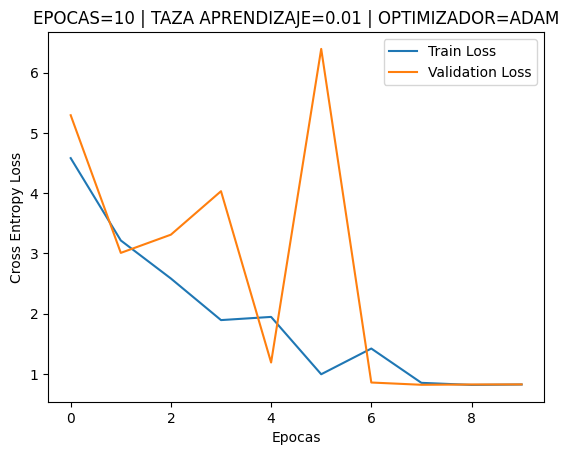

In [29]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 2.9501
Epoch [1/15]	Validation	Loss: 6.3764	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 3.5925
Epoch [2/15]	Validation	Loss: 6.0673	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 2.3099
Epoch [3/15]	Validation	Loss: 8.7614	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 2.6555
Epoch [4/15]	Validation	Loss: 8.2373	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 1.5515
Epoch [5/15]	Validation	Loss: 8.1756	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 1.4706
Epoch [6/15]	Validation	Loss: 7.4845	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 2.2482
Epoch [7/15]	Validation	Loss: 4.1792	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 0.8147
Epoch [8/15]	Validation	Loss: 2.4750	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 0.8167
Epoch [9/15]	Validation	Loss: 2.6041	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 0.7632
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


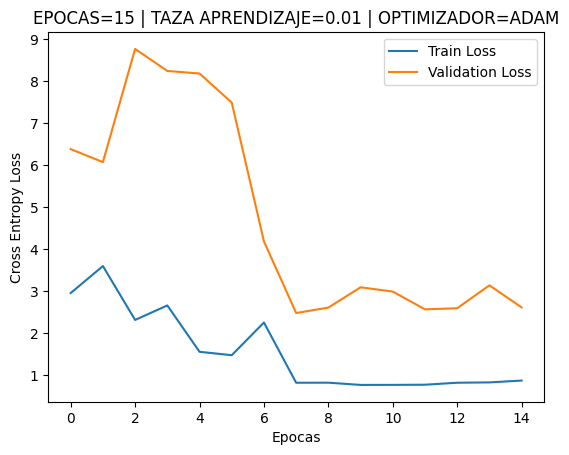

In [30]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 2.3206
Epoch [1/20]	Validation	Loss: 0.7437	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 0.8556
Epoch [2/20]	Validation	Loss: 0.7874	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.7990
Epoch [3/20]	Validation	Loss: 0.6930	Validation Accuracy: 51.5%
Epoch [4/20]	Training [20%]	Loss: 0.7858
Epoch [4/20]	Validation	Loss: 0.6953	Validation Accuracy: 48.5%
Epoch [5/20]	Training [25%]	Loss: 0.7476
Epoch [5/20]	Validation	Loss: 0.6998	Validation Accuracy: 48.0%
Epoch [6/20]	Training [30%]	Loss: 0.7850
Epoch [6/20]	Validation	Loss: 0.7752	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 0.7514
Epoch [7/20]	Validation	Loss: 0.7219	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 0.7173
Epoch [8/20]	Validation	Loss: 0.7070	Validation Accuracy: 49.5%
Epoch [9/20]	Training [45%]	Loss: 0.7435
Epoch [9/20]	Validation	Loss: 0.8109	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 0.7672
Epoch [10/20]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


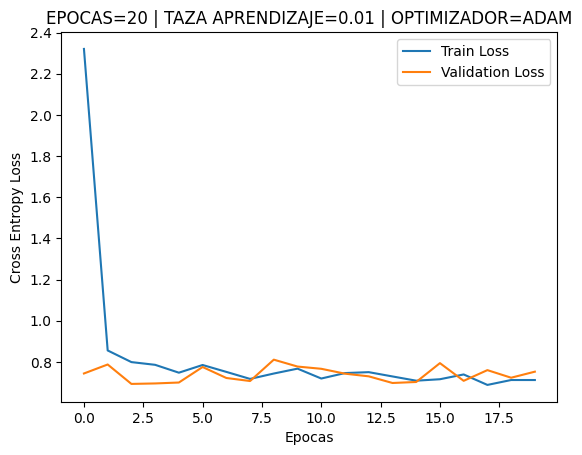

In [31]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 2.2017
Epoch [1/5]	Validation	Loss: 1.0083	Validation Accuracy: 62.0%
Epoch [2/5]	Training [40%]	Loss: 1.1541
Epoch [2/5]	Validation	Loss: 0.5367	Validation Accuracy: 75.0%
Epoch [3/5]	Training [60%]	Loss: 1.0491
Epoch [3/5]	Validation	Loss: 0.6887	Validation Accuracy: 68.5%
Epoch [4/5]	Training [80%]	Loss: 1.0392
Epoch [4/5]	Validation	Loss: 0.6708	Validation Accuracy: 61.5%
Epoch [5/5]	Training [100%]	Loss: 1.0001
Epoch [5/5]	Validation	Loss: 0.5818	Validation Accuracy: 71.0%
Performance on the test data:
	Loss: 0.5818
	Accuracy: 71.0%
	precision: 81.6%
	recall: 71.0%
	f_score: 68.3%
(0.8164556962025317, 0.71, 0.6833715471121302, None)

Confusion Matrix:
[[100   0]
 [ 58  42]]


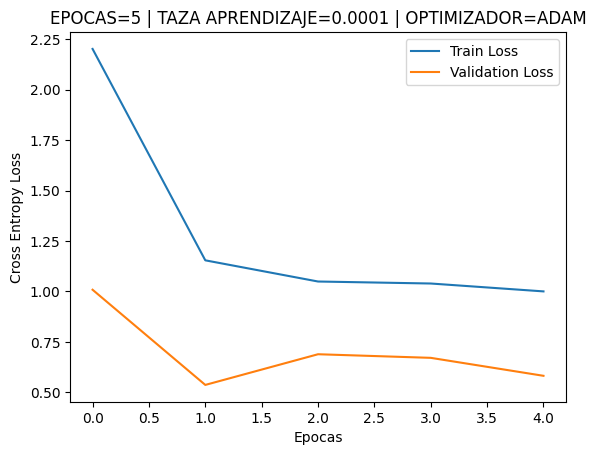

In [32]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 2.6504
Epoch [1/10]	Validation	Loss: 0.7384	Validation Accuracy: 70.5%
Epoch [2/10]	Training [20%]	Loss: 1.1302
Epoch [2/10]	Validation	Loss: 0.6169	Validation Accuracy: 73.0%
Epoch [3/10]	Training [30%]	Loss: 1.2247
Epoch [3/10]	Validation	Loss: 0.5832	Validation Accuracy: 73.5%
Epoch [4/10]	Training [40%]	Loss: 0.9693
Epoch [4/10]	Validation	Loss: 1.1429	Validation Accuracy: 58.5%
Epoch [5/10]	Training [50%]	Loss: 1.0361
Epoch [5/10]	Validation	Loss: 0.5357	Validation Accuracy: 76.0%
Epoch [6/10]	Training [60%]	Loss: 0.8380
Epoch [6/10]	Validation	Loss: 0.5247	Validation Accuracy: 75.5%
Epoch [7/10]	Training [70%]	Loss: 0.9809
Epoch [7/10]	Validation	Loss: 0.9521	Validation Accuracy: 55.0%
Epoch [8/10]	Training [80%]	Loss: 0.7985
Epoch [8/10]	Validation	Loss: 1.1326	Validation Accuracy: 52.0%
Epoch [9/10]	Training [90%]	Loss: 0.8518
Epoch [9/10]	Validation	Loss: 0.9062	Validation Accuracy: 58.5%
Epoch [10/10]	Training [100%]	Loss: 0.8229
Epoch [10/10

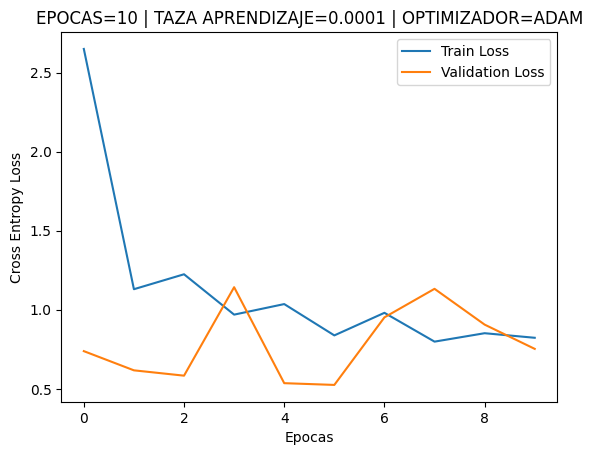

In [33]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 2.1408
Epoch [1/15]	Validation	Loss: 0.6933	Validation Accuracy: 68.5%
Epoch [2/15]	Training [13%]	Loss: 1.0638
Epoch [2/15]	Validation	Loss: 0.5911	Validation Accuracy: 73.5%
Epoch [3/15]	Training [20%]	Loss: 1.0588
Epoch [3/15]	Validation	Loss: 0.6303	Validation Accuracy: 73.0%
Epoch [4/15]	Training [27%]	Loss: 1.1725
Epoch [4/15]	Validation	Loss: 0.6893	Validation Accuracy: 71.0%
Epoch [5/15]	Training [33%]	Loss: 1.0395
Epoch [5/15]	Validation	Loss: 0.6705	Validation Accuracy: 70.0%
Epoch [6/15]	Training [40%]	Loss: 0.9421
Epoch [6/15]	Validation	Loss: 0.8771	Validation Accuracy: 65.5%
Epoch [7/15]	Training [47%]	Loss: 0.9346
Epoch [7/15]	Validation	Loss: 0.5026	Validation Accuracy: 77.5%
Epoch [8/15]	Training [53%]	Loss: 0.7796
Epoch [8/15]	Validation	Loss: 0.8378	Validation Accuracy: 65.0%
Epoch [9/15]	Training [60%]	Loss: 0.8797
Epoch [9/15]	Validation	Loss: 0.6131	Validation Accuracy: 71.0%
Epoch [10/15]	Training [67%]	Loss: 0.8356
Epoch [10/15]	

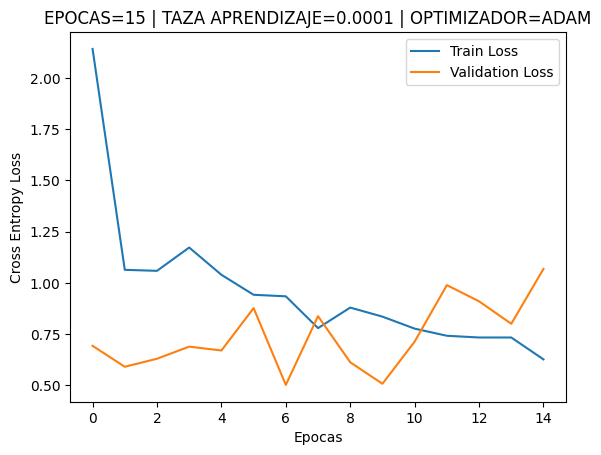

In [34]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\3055852769.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 2.4711
Epoch [1/20]	Validation	Loss: 0.6767	Validation Accuracy: 70.5%
Epoch [2/20]	Training [10%]	Loss: 1.1641
Epoch [2/20]	Validation	Loss: 0.8010	Validation Accuracy: 69.0%
Epoch [3/20]	Training [15%]	Loss: 0.8561
Epoch [3/20]	Validation	Loss: 1.1118	Validation Accuracy: 64.5%
Epoch [4/20]	Training [20%]	Loss: 0.9540
Epoch [4/20]	Validation	Loss: 0.8303	Validation Accuracy: 63.5%
Epoch [5/20]	Training [25%]	Loss: 0.9113
Epoch [5/20]	Validation	Loss: 0.6512	Validation Accuracy: 71.0%
Epoch [6/20]	Training [30%]	Loss: 0.9323
Epoch [6/20]	Validation	Loss: 0.7001	Validation Accuracy: 69.5%
Epoch [7/20]	Training [35%]	Loss: 0.9265
Epoch [7/20]	Validation	Loss: 0.6497	Validation Accuracy: 70.0%
Epoch [8/20]	Training [40%]	Loss: 0.9728
Epoch [8/20]	Validation	Loss: 0.8035	Validation Accuracy: 68.0%
Epoch [9/20]	Training [45%]	Loss: 0.7959
Epoch [9/20]	Validation	Loss: 0.6953	Validation Accuracy: 69.0%
Epoch [10/20]	Training [50%]	Loss: 0.7800
Epoch [10/20]	

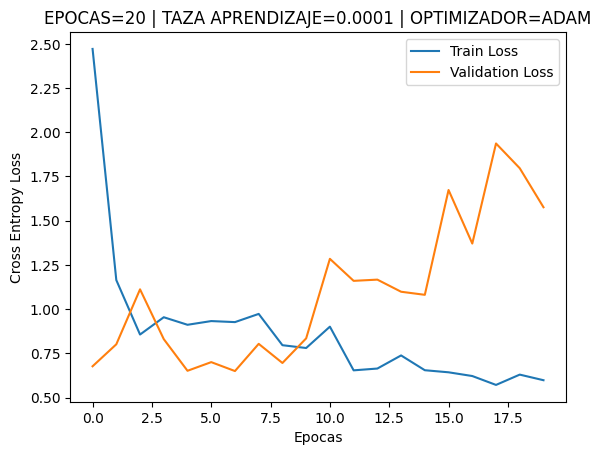

In [35]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

--------------------------------------SGD-----------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 3.7618
Epoch [1/5]	Validation	Loss: 1.5088	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.8993
Epoch [2/5]	Validation	Loss: 0.7573	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.7669
Epoch [3/5]	Validation	Loss: 0.6778	Validation Accuracy: 53.5%
Epoch [4/5]	Training [80%]	Loss: 0.7277
Epoch [4/5]	Validation	Loss: 0.5863	Validation Accuracy: 74.5%
Epoch [5/5]	Training [100%]	Loss: 0.6790
Epoch [5/5]	Validation	Loss: 0.5719	Validation Accuracy: 73.5%
Performance on the test data:
	Loss: 0.5719
	Accuracy: 73.5%
	precision: 82.7%
	recall: 73.5%
	f_score: 71.5%
(0.826797385620915, 0.735, 0.7149848081525101, None)

Confusion Matrix:
[[100   0]
 [ 53  47]]


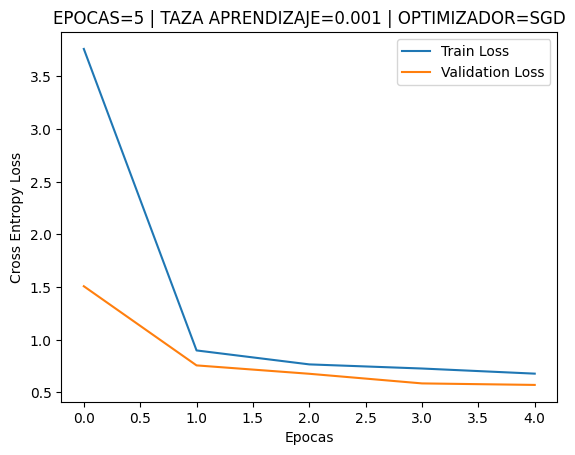

In [40]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 3.3327
Epoch [1/10]	Validation	Loss: 2.7346	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 1.1316
Epoch [2/10]	Validation	Loss: 0.8135	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 0.8004
Epoch [3/10]	Validation	Loss: 0.7793	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 0.8164
Epoch [4/10]	Validation	Loss: 0.7844	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 0.7622
Epoch [5/10]	Validation	Loss: 0.7782	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 0.6832
Epoch [6/10]	Validation	Loss: 0.7301	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 0.6134
Epoch [7/10]	Validation	Loss: 0.5295	Validation Accuracy: 82.0%
Epoch [8/10]	Training [80%]	Loss: 0.6105
Epoch [8/10]	Validation	Loss: 0.5292	Validation Accuracy: 82.5%
Epoch [9/10]	Training [90%]	Loss: 0.6472
Epoch [9/10]	Validation	Loss: 0.5895	Validation Accuracy: 67.5%
Epoch [10/10]	Training [100%]	Loss: 0.6021
Epoch [10/10

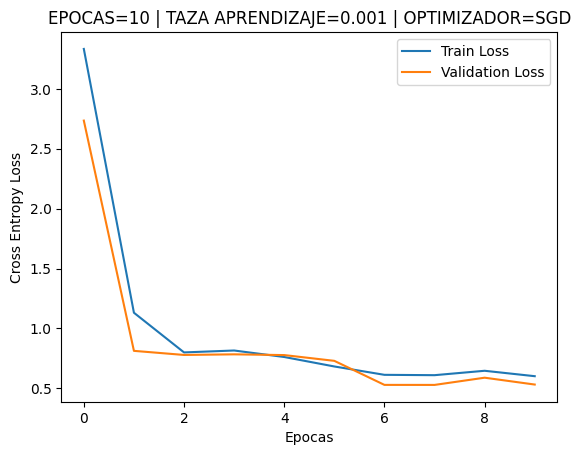

In [41]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 4.1689
Epoch [1/15]	Validation	Loss: 2.1317	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 0.8217
Epoch [2/15]	Validation	Loss: 0.7071	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 0.7717
Epoch [3/15]	Validation	Loss: 0.6458	Validation Accuracy: 75.0%
Epoch [4/15]	Training [27%]	Loss: 0.7366
Epoch [4/15]	Validation	Loss: 0.5858	Validation Accuracy: 80.5%
Epoch [5/15]	Training [33%]	Loss: 0.6698
Epoch [5/15]	Validation	Loss: 0.5664	Validation Accuracy: 74.5%
Epoch [6/15]	Training [40%]	Loss: 0.6196
Epoch [6/15]	Validation	Loss: 0.5293	Validation Accuracy: 82.5%
Epoch [7/15]	Training [47%]	Loss: 0.5939
Epoch [7/15]	Validation	Loss: 0.5557	Validation Accuracy: 72.0%
Epoch [8/15]	Training [53%]	Loss: 0.5908
Epoch [8/15]	Validation	Loss: 0.6588	Validation Accuracy: 61.5%
Epoch [9/15]	Training [60%]	Loss: 0.5905
Epoch [9/15]	Validation	Loss: 0.5200	Validation Accuracy: 76.0%
Epoch [10/15]	Training [67%]	Loss: 0.5572
Epoch [10/15]	

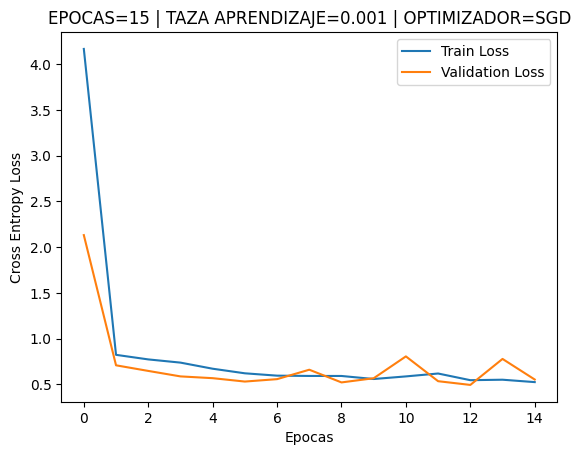

In [43]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 2.9616
Epoch [1/20]	Validation	Loss: 3.1664	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 1.0400
Epoch [2/20]	Validation	Loss: 0.6724	Validation Accuracy: 50.5%
Epoch [3/20]	Training [15%]	Loss: 0.7848
Epoch [3/20]	Validation	Loss: 0.6678	Validation Accuracy: 54.5%
Epoch [4/20]	Training [20%]	Loss: 0.7554
Epoch [4/20]	Validation	Loss: 0.6697	Validation Accuracy: 58.0%
Epoch [5/20]	Training [25%]	Loss: 0.6961
Epoch [5/20]	Validation	Loss: 0.5806	Validation Accuracy: 71.5%
Epoch [6/20]	Training [30%]	Loss: 0.6636
Epoch [6/20]	Validation	Loss: 0.5927	Validation Accuracy: 79.0%
Epoch [7/20]	Training [35%]	Loss: 0.6363
Epoch [7/20]	Validation	Loss: 0.5456	Validation Accuracy: 86.0%
Epoch [8/20]	Training [40%]	Loss: 0.6322
Epoch [8/20]	Validation	Loss: 0.5720	Validation Accuracy: 72.5%
Epoch [9/20]	Training [45%]	Loss: 0.5963
Epoch [9/20]	Validation	Loss: 0.5724	Validation Accuracy: 67.5%
Epoch [10/20]	Training [50%]	Loss: 0.5794
Epoch [10/20]	

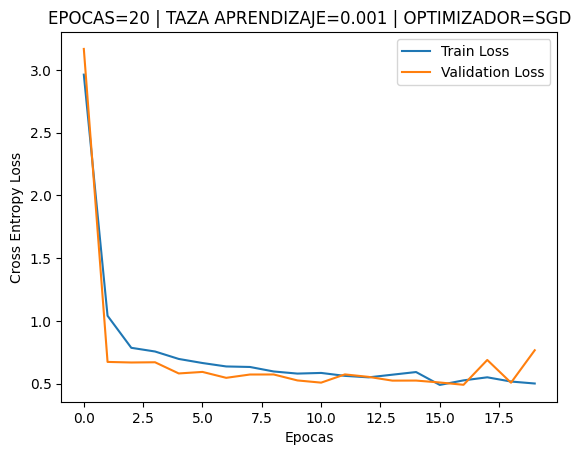

In [44]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 1.4535
Epoch [1/5]	Validation	Loss: 0.6910	Validation Accuracy: 52.5%
Epoch [2/5]	Training [40%]	Loss: 0.7338
Epoch [2/5]	Validation	Loss: 0.7231	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.7178
Epoch [3/5]	Validation	Loss: 0.7129	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 0.7331
Epoch [4/5]	Validation	Loss: 0.7013	Validation Accuracy: 49.0%
Epoch [5/5]	Training [100%]	Loss: 0.7325
Epoch [5/5]	Validation	Loss: 0.7798	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 0.7798
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[  0 100]
 [  0 100]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


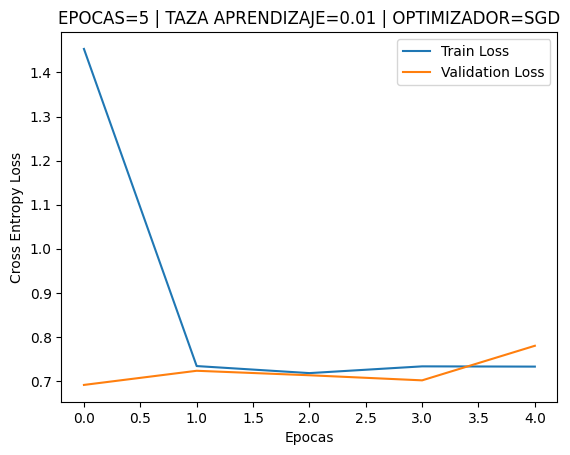

In [45]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 1.6934
Epoch [1/10]	Validation	Loss: 0.7054	Validation Accuracy: 49.5%
Epoch [2/10]	Training [20%]	Loss: 0.7351
Epoch [2/10]	Validation	Loss: 0.7017	Validation Accuracy: 48.5%
Epoch [3/10]	Training [30%]	Loss: 0.7258
Epoch [3/10]	Validation	Loss: 0.7443	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 0.7288
Epoch [4/10]	Validation	Loss: 0.6650	Validation Accuracy: 61.5%
Epoch [5/10]	Training [50%]	Loss: 0.7240
Epoch [5/10]	Validation	Loss: 0.6959	Validation Accuracy: 51.5%
Epoch [6/10]	Training [60%]	Loss: 0.7195
Epoch [6/10]	Validation	Loss: 0.7000	Validation Accuracy: 49.5%
Epoch [7/10]	Training [70%]	Loss: 0.7117
Epoch [7/10]	Validation	Loss: 0.6757	Validation Accuracy: 57.0%
Epoch [8/10]	Training [80%]	Loss: 0.6926
Epoch [8/10]	Validation	Loss: 0.6829	Validation Accuracy: 51.5%
Epoch [9/10]	Training [90%]	Loss: 0.7041
Epoch [9/10]	Validation	Loss: 0.7302	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 0.7493
Epoch [10/10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


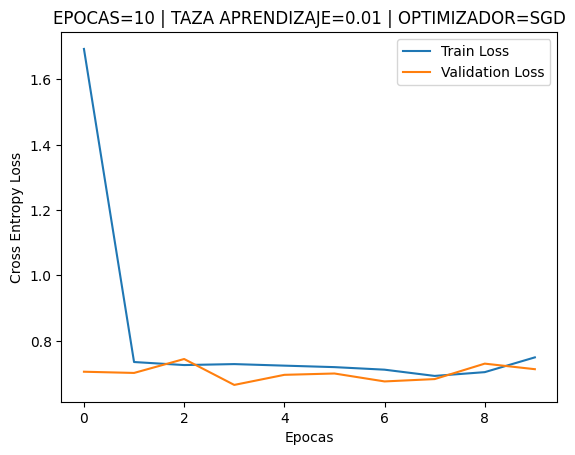

In [47]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 1.8052
Epoch [1/15]	Validation	Loss: 0.7205	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 0.7432
Epoch [2/15]	Validation	Loss: 0.7166	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 0.7213
Epoch [3/15]	Validation	Loss: 1.7009	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 0.7586
Epoch [4/15]	Validation	Loss: 0.7463	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 0.7656
Epoch [5/15]	Validation	Loss: 0.6966	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 0.7200
Epoch [6/15]	Validation	Loss: 0.6895	Validation Accuracy: 51.0%
Epoch [7/15]	Training [47%]	Loss: 0.7352
Epoch [7/15]	Validation	Loss: 0.7041	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 0.7117
Epoch [8/15]	Validation	Loss: 1.2372	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 0.7402
Epoch [9/15]	Validation	Loss: 0.7036	Validation Accuracy: 44.0%
Epoch [10/15]	Training [67%]	Loss: 0.7198
Epoch [10/15]	

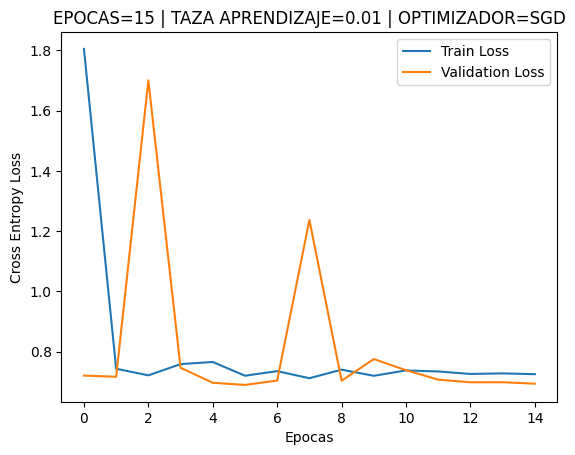

In [48]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 1.3740
Epoch [1/20]	Validation	Loss: 0.7242	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 0.7217
Epoch [2/20]	Validation	Loss: 0.6371	Validation Accuracy: 62.5%
Epoch [3/20]	Training [15%]	Loss: 0.6790
Epoch [3/20]	Validation	Loss: 0.5741	Validation Accuracy: 73.0%
Epoch [4/20]	Training [20%]	Loss: 0.6610
Epoch [4/20]	Validation	Loss: 0.5708	Validation Accuracy: 73.5%
Epoch [5/20]	Training [25%]	Loss: 0.5896
Epoch [5/20]	Validation	Loss: 0.5167	Validation Accuracy: 79.5%
Epoch [6/20]	Training [30%]	Loss: 0.5179
Epoch [6/20]	Validation	Loss: 0.5867	Validation Accuracy: 75.5%
Epoch [7/20]	Training [35%]	Loss: 0.5556
Epoch [7/20]	Validation	Loss: 0.6372	Validation Accuracy: 74.0%
Epoch [8/20]	Training [40%]	Loss: 0.5311
Epoch [8/20]	Validation	Loss: 0.5044	Validation Accuracy: 80.5%
Epoch [9/20]	Training [45%]	Loss: 0.5321
Epoch [9/20]	Validation	Loss: 0.8976	Validation Accuracy: 74.0%
Epoch [10/20]	Training [50%]	Loss: 0.5095
Epoch [10/20]	

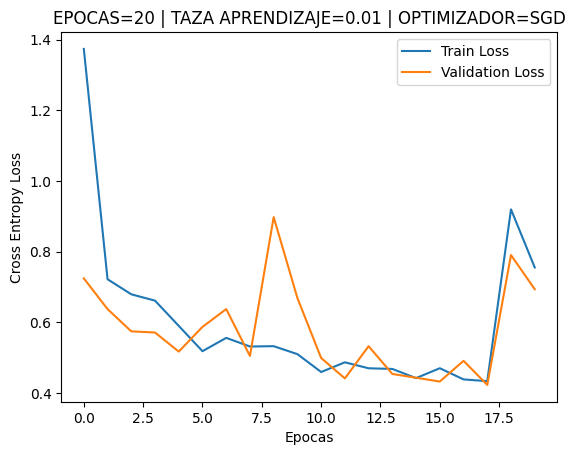

In [52]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 4.9712
Epoch [1/5]	Validation	Loss: 4.9400	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 4.9792
Epoch [2/5]	Validation	Loss: 4.9473	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 4.8687
Epoch [3/5]	Validation	Loss: 4.7857	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 3.6841
Epoch [4/5]	Validation	Loss: 0.6015	Validation Accuracy: 75.5%
Epoch [5/5]	Training [100%]	Loss: 1.2690
Epoch [5/5]	Validation	Loss: 0.6795	Validation Accuracy: 72.0%
Performance on the test data:
	Loss: 0.6795
	Accuracy: 72.0%
	precision: 82.1%
	recall: 72.0%
	f_score: 69.6%
(0.8205128205128205, 0.72, 0.6961805555555556, None)

Confusion Matrix:
[[100   0]
 [ 56  44]]


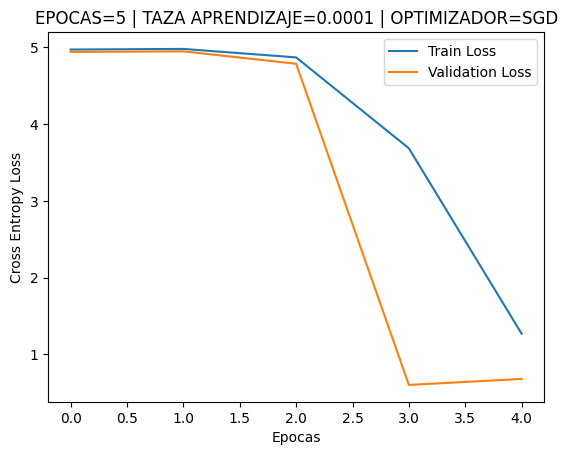

In [53]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 5.0233
Epoch [1/10]	Validation	Loss: 4.9907	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 4.9848
Epoch [2/10]	Validation	Loss: 4.9764	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 4.9963
Epoch [3/10]	Validation	Loss: 4.9890	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 4.9937
Epoch [4/10]	Validation	Loss: 4.9594	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 4.9295
Epoch [5/10]	Validation	Loss: 4.9056	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 4.8404
Epoch [6/10]	Validation	Loss: 4.7015	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 2.9900
Epoch [7/10]	Validation	Loss: 1.3159	Validation Accuracy: 56.0%
Epoch [8/10]	Training [80%]	Loss: 1.4119
Epoch [8/10]	Validation	Loss: 1.0834	Validation Accuracy: 60.5%
Epoch [9/10]	Training [90%]	Loss: 1.2178
Epoch [9/10]	Validation	Loss: 0.9046	Validation Accuracy: 63.0%
Epoch [10/10]	Training [100%]	Loss: 1.1256
Epoch [10/10

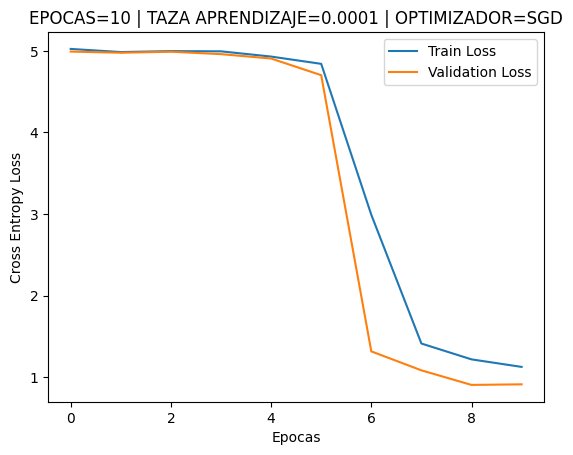

In [54]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 4.9837
Epoch [1/15]	Validation	Loss: 4.9750	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 4.9193
Epoch [2/15]	Validation	Loss: 4.8673	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 4.5284
Epoch [3/15]	Validation	Loss: 3.4136	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 1.8346
Epoch [4/15]	Validation	Loss: 0.4884	Validation Accuracy: 81.0%
Epoch [5/15]	Training [33%]	Loss: 1.1999
Epoch [5/15]	Validation	Loss: 0.7518	Validation Accuracy: 64.0%
Epoch [6/15]	Training [40%]	Loss: 0.9594
Epoch [6/15]	Validation	Loss: 0.5179	Validation Accuracy: 77.5%
Epoch [7/15]	Training [47%]	Loss: 0.9022
Epoch [7/15]	Validation	Loss: 0.5181	Validation Accuracy: 78.5%
Epoch [8/15]	Training [53%]	Loss: 0.8817
Epoch [8/15]	Validation	Loss: 0.7103	Validation Accuracy: 65.0%
Epoch [9/15]	Training [60%]	Loss: 0.9651
Epoch [9/15]	Validation	Loss: 0.9834	Validation Accuracy: 53.5%
Epoch [10/15]	Training [67%]	Loss: 0.7548
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


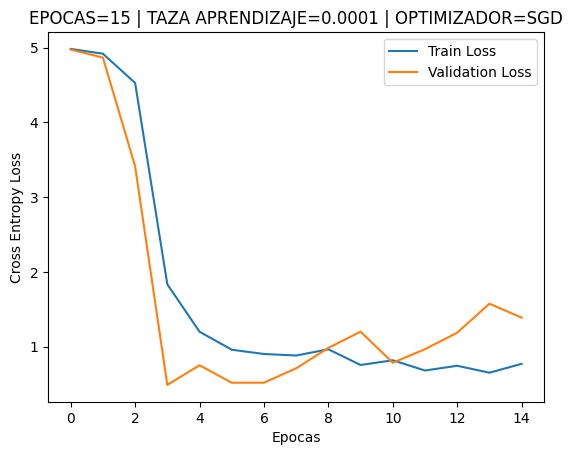

In [55]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 4.9965
Epoch [1/20]	Validation	Loss: 5.0031	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 4.9568
Epoch [2/20]	Validation	Loss: 4.9750	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 4.9099
Epoch [3/20]	Validation	Loss: 4.8667	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 3.8518
Epoch [4/20]	Validation	Loss: 0.9357	Validation Accuracy: 63.0%
Epoch [5/20]	Training [25%]	Loss: 1.3809
Epoch [5/20]	Validation	Loss: 0.6700	Validation Accuracy: 72.5%
Epoch [6/20]	Training [30%]	Loss: 1.0916
Epoch [6/20]	Validation	Loss: 0.8074	Validation Accuracy: 65.0%
Epoch [7/20]	Training [35%]	Loss: 1.0574
Epoch [7/20]	Validation	Loss: 0.9333	Validation Accuracy: 61.0%
Epoch [8/20]	Training [40%]	Loss: 0.8654
Epoch [8/20]	Validation	Loss: 0.5176	Validation Accuracy: 77.5%
Epoch [9/20]	Training [45%]	Loss: 0.9222
Epoch [9/20]	Validation	Loss: 0.9698	Validation Accuracy: 60.0%
Epoch [10/20]	Training [50%]	Loss: 0.7355
Epoch [10/20]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


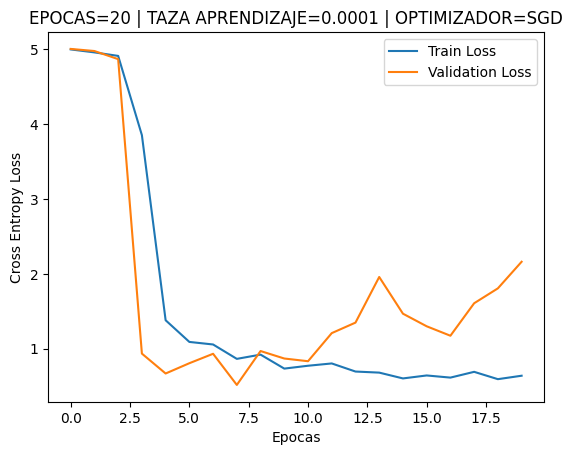

In [56]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------Adadelta--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 5.0352
Epoch [1/5]	Validation	Loss: 5.0052	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 4.9955
Epoch [2/5]	Validation	Loss: 4.9963	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 4.9771
Epoch [3/5]	Validation	Loss: 4.9907	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 5.0106
Epoch [4/5]	Validation	Loss: 5.0180	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 5.0248
Epoch [5/5]	Validation	Loss: 5.0004	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 5.0004
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


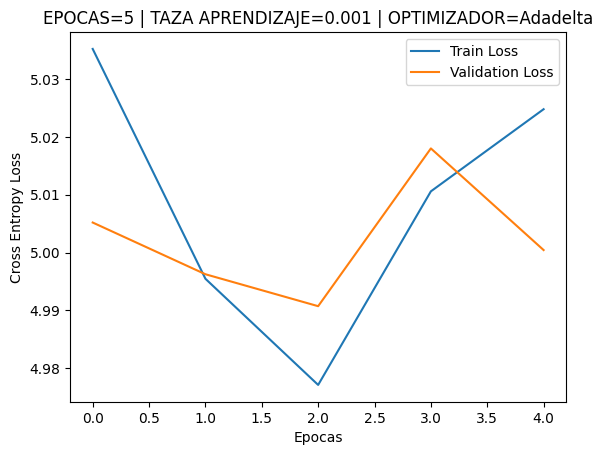

In [57]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 5.0306
Epoch [1/10]	Validation	Loss: 5.0062	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 5.0158
Epoch [2/10]	Validation	Loss: 5.0432	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 5.0044
Epoch [3/10]	Validation	Loss: 4.9830	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 5.0314
Epoch [4/10]	Validation	Loss: 5.0024	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 5.0022
Epoch [5/10]	Validation	Loss: 4.9657	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 4.9755
Epoch [6/10]	Validation	Loss: 5.0061	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 4.9594
Epoch [7/10]	Validation	Loss: 4.9883	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 4.9928
Epoch [8/10]	Validation	Loss: 4.9676	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 4.9598
Epoch [9/10]	Validation	Loss: 4.9493	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 4.9630
Epoch [10/10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


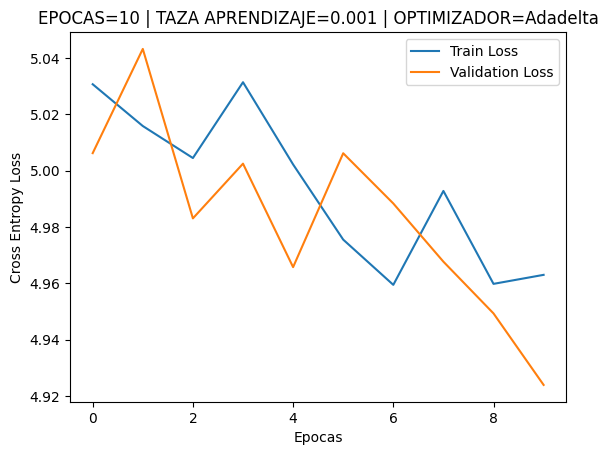

In [58]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 5.0139
Epoch [1/15]	Validation	Loss: 5.0072	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 4.9927
Epoch [2/15]	Validation	Loss: 4.9833	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 4.9714
Epoch [3/15]	Validation	Loss: 4.9339	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 4.9479
Epoch [4/15]	Validation	Loss: 4.9130	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 4.9088
Epoch [5/15]	Validation	Loss: 4.9291	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 4.8538
Epoch [6/15]	Validation	Loss: 4.8706	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 4.8627
Epoch [7/15]	Validation	Loss: 4.8197	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 4.7912
Epoch [8/15]	Validation	Loss: 4.7794	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 4.7734
Epoch [9/15]	Validation	Loss: 4.6933	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 4.6323
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


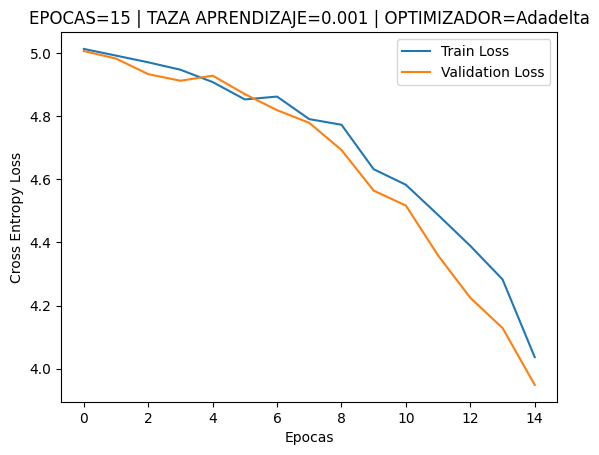

In [59]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 4.9831
Epoch [1/20]	Validation	Loss: 4.9942	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 4.9625
Epoch [2/20]	Validation	Loss: 4.9411	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 4.9468
Epoch [3/20]	Validation	Loss: 4.9064	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 4.8705
Epoch [4/20]	Validation	Loss: 4.8100	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 4.8487
Epoch [5/20]	Validation	Loss: 4.7310	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 4.7070
Epoch [6/20]	Validation	Loss: 4.6325	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 4.6116
Epoch [7/20]	Validation	Loss: 4.4676	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 4.4425
Epoch [8/20]	Validation	Loss: 4.2982	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 4.3510
Epoch [9/20]	Validation	Loss: 4.0946	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 4.2271
Epoch [10/20]	

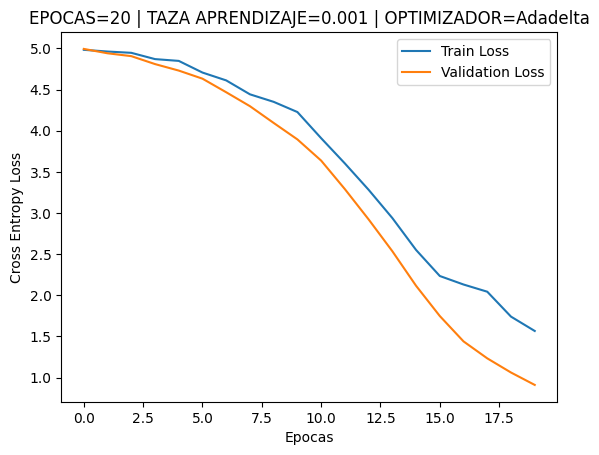

In [60]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ********************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 4.9537
Epoch [1/5]	Validation	Loss: 4.7739	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 4.0792
Epoch [2/5]	Validation	Loss: 3.3030	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 2.6241
Epoch [3/5]	Validation	Loss: 1.1398	Validation Accuracy: 60.0%
Epoch [4/5]	Training [80%]	Loss: 1.2798
Epoch [4/5]	Validation	Loss: 0.7311	Validation Accuracy: 70.0%
Epoch [5/5]	Training [100%]	Loss: 1.4424
Epoch [5/5]	Validation	Loss: 0.5773	Validation Accuracy: 75.5%
Performance on the test data:
	Loss: 0.5773
	Accuracy: 75.5%
	precision: 83.6%
	recall: 75.5%
	f_score: 73.9%
(0.8355704697986577, 0.755, 0.7393547700736722, None)

Confusion Matrix:
[[100   0]
 [ 49  51]]


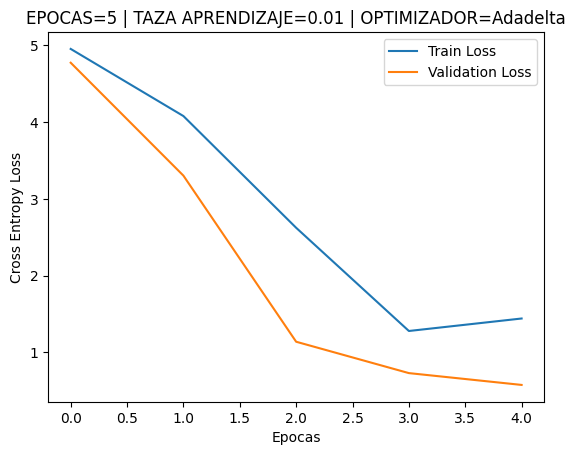

In [61]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 4.9418
Epoch [1/10]	Validation	Loss: 4.8043	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 4.3293
Epoch [2/10]	Validation	Loss: 3.3478	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 2.4587
Epoch [3/10]	Validation	Loss: 0.7656	Validation Accuracy: 69.5%
Epoch [4/10]	Training [40%]	Loss: 1.3511
Epoch [4/10]	Validation	Loss: 0.5617	Validation Accuracy: 74.5%
Epoch [5/10]	Training [50%]	Loss: 1.2610
Epoch [5/10]	Validation	Loss: 0.5551	Validation Accuracy: 75.5%
Epoch [6/10]	Training [60%]	Loss: 1.3962
Epoch [6/10]	Validation	Loss: 0.5913	Validation Accuracy: 74.0%
Epoch [7/10]	Training [70%]	Loss: 1.1517
Epoch [7/10]	Validation	Loss: 0.5915	Validation Accuracy: 75.0%
Epoch [8/10]	Training [80%]	Loss: 1.2773
Epoch [8/10]	Validation	Loss: 0.5688	Validation Accuracy: 75.5%
Epoch [9/10]	Training [90%]	Loss: 1.0043
Epoch [9/10]	Validation	Loss: 0.5660	Validation Accuracy: 75.5%
Epoch [10/10]	Training [100%]	Loss: 1.2074
Epoch [10/10

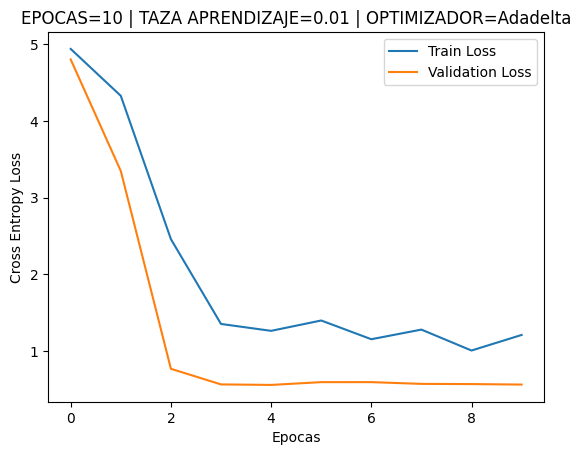

In [62]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 4.9642
Epoch [1/15]	Validation	Loss: 4.8152	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 4.3250
Epoch [2/15]	Validation	Loss: 3.3770	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 2.3174
Epoch [3/15]	Validation	Loss: 0.8055	Validation Accuracy: 68.0%
Epoch [4/15]	Training [27%]	Loss: 1.3413
Epoch [4/15]	Validation	Loss: 0.6106	Validation Accuracy: 73.5%
Epoch [5/15]	Training [33%]	Loss: 1.0542
Epoch [5/15]	Validation	Loss: 0.5699	Validation Accuracy: 77.0%
Epoch [6/15]	Training [40%]	Loss: 1.2327
Epoch [6/15]	Validation	Loss: 0.5851	Validation Accuracy: 73.5%
Epoch [7/15]	Training [47%]	Loss: 1.2249
Epoch [7/15]	Validation	Loss: 0.6206	Validation Accuracy: 72.5%
Epoch [8/15]	Training [53%]	Loss: 1.1550
Epoch [8/15]	Validation	Loss: 0.5895	Validation Accuracy: 76.0%
Epoch [9/15]	Training [60%]	Loss: 1.0354
Epoch [9/15]	Validation	Loss: 0.6070	Validation Accuracy: 74.0%
Epoch [10/15]	Training [67%]	Loss: 1.1198
Epoch [10/15]	

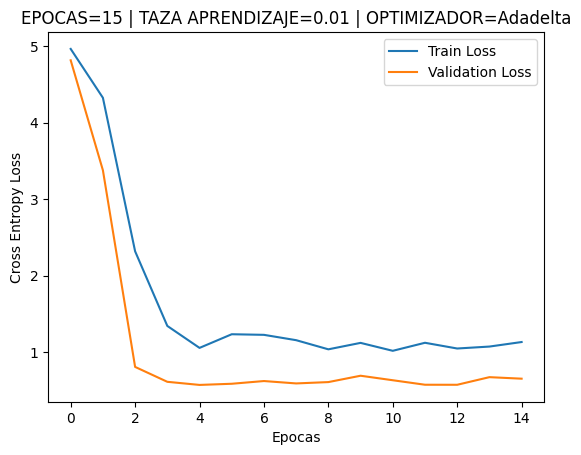

In [63]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 4.7443
Epoch [1/20]	Validation	Loss: 4.0878	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 2.8118
Epoch [2/20]	Validation	Loss: 0.9699	Validation Accuracy: 64.0%
Epoch [3/20]	Training [15%]	Loss: 1.2648
Epoch [3/20]	Validation	Loss: 0.6403	Validation Accuracy: 73.5%
Epoch [4/20]	Training [20%]	Loss: 1.2487
Epoch [4/20]	Validation	Loss: 0.5792	Validation Accuracy: 75.5%
Epoch [5/20]	Training [25%]	Loss: 1.0291
Epoch [5/20]	Validation	Loss: 0.5475	Validation Accuracy: 75.5%
Epoch [6/20]	Training [30%]	Loss: 1.1579
Epoch [6/20]	Validation	Loss: 0.5496	Validation Accuracy: 75.5%
Epoch [7/20]	Training [35%]	Loss: 1.4088
Epoch [7/20]	Validation	Loss: 0.5439	Validation Accuracy: 77.5%
Epoch [8/20]	Training [40%]	Loss: 1.1793
Epoch [8/20]	Validation	Loss: 0.5346	Validation Accuracy: 77.0%
Epoch [9/20]	Training [45%]	Loss: 1.2647
Epoch [9/20]	Validation	Loss: 0.5623	Validation Accuracy: 75.0%
Epoch [10/20]	Training [50%]	Loss: 1.0476
Epoch [10/20]	

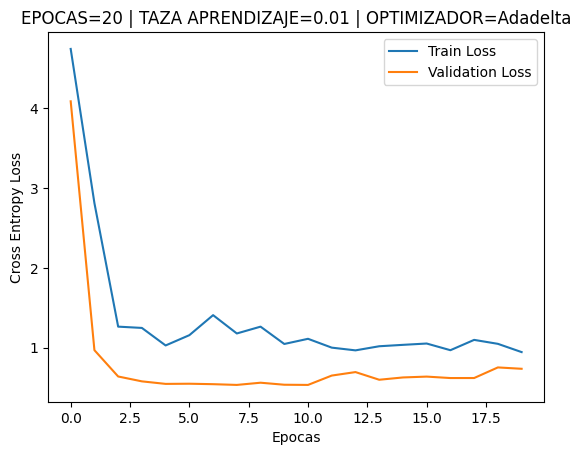

In [64]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 4.9711
Epoch [1/5]	Validation	Loss: 4.9830	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 5.0001
Epoch [2/5]	Validation	Loss: 5.0047	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 5.0020
Epoch [3/5]	Validation	Loss: 4.9945	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 5.0004
Epoch [4/5]	Validation	Loss: 4.9641	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 5.0017
Epoch [5/5]	Validation	Loss: 4.9780	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 4.9780
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


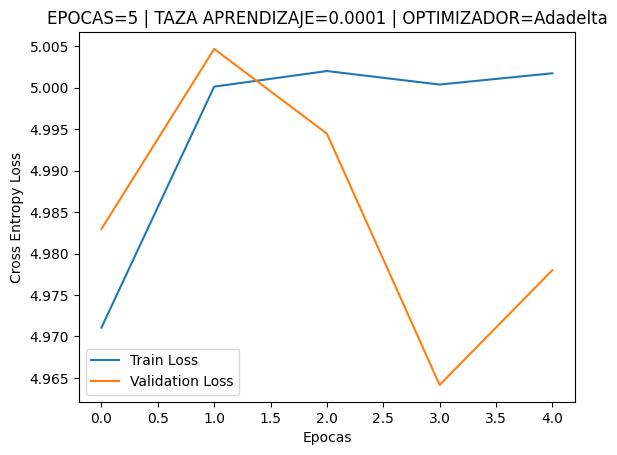

In [65]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 4.9911
Epoch [1/10]	Validation	Loss: 5.0142	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 4.9764
Epoch [2/10]	Validation	Loss: 5.0000	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 5.0187
Epoch [3/10]	Validation	Loss: 4.9948	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 5.0077
Epoch [4/10]	Validation	Loss: 5.0030	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 4.9961
Epoch [5/10]	Validation	Loss: 5.0216	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 5.0125
Epoch [6/10]	Validation	Loss: 4.9991	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 5.0125
Epoch [7/10]	Validation	Loss: 4.9960	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 4.9962
Epoch [8/10]	Validation	Loss: 4.9925	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 4.9786
Epoch [9/10]	Validation	Loss: 5.0032	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 4.9642
Epoch [10/10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


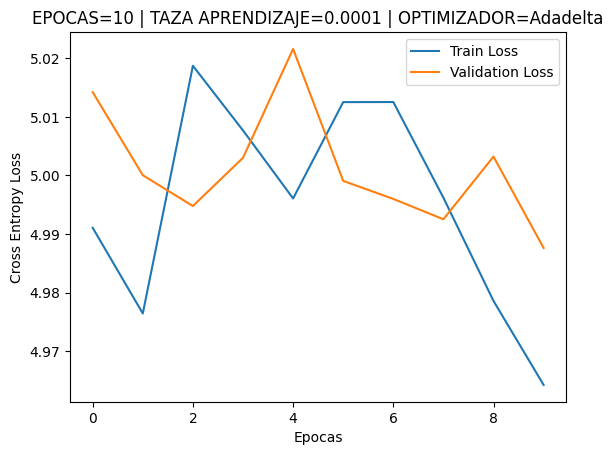

In [66]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 5.0214
Epoch [1/15]	Validation	Loss: 4.9883	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 5.0529
Epoch [2/15]	Validation	Loss: 5.0352	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 5.0329
Epoch [3/15]	Validation	Loss: 5.0378	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 5.0165
Epoch [4/15]	Validation	Loss: 5.0286	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 5.0323
Epoch [5/15]	Validation	Loss: 5.0128	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 5.0343
Epoch [6/15]	Validation	Loss: 5.0384	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 5.0470
Epoch [7/15]	Validation	Loss: 5.0127	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 4.9942
Epoch [8/15]	Validation	Loss: 4.9837	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 5.0161
Epoch [9/15]	Validation	Loss: 5.0514	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 5.0049
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


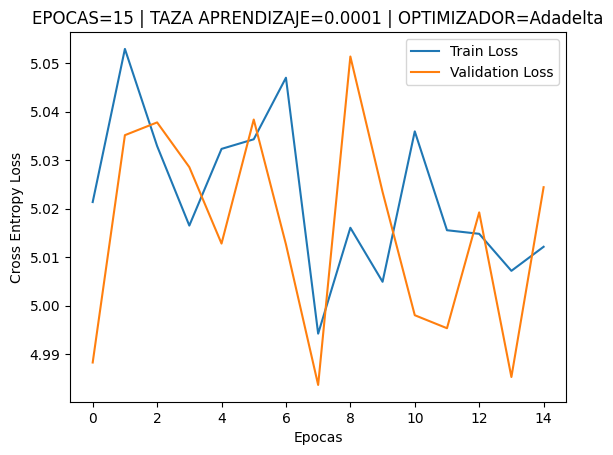

In [67]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 4.9847
Epoch [1/20]	Validation	Loss: 4.9876	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 4.9750
Epoch [2/20]	Validation	Loss: 5.0074	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 5.0012
Epoch [3/20]	Validation	Loss: 4.9568	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 4.9835
Epoch [4/20]	Validation	Loss: 5.0089	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 4.9890
Epoch [5/20]	Validation	Loss: 5.0050	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 4.9910
Epoch [6/20]	Validation	Loss: 4.9889	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 4.9889
Epoch [7/20]	Validation	Loss: 5.0101	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 4.9757
Epoch [8/20]	Validation	Loss: 4.9823	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 4.9879
Epoch [9/20]	Validation	Loss: 4.9962	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 4.9724
Epoch [10/20]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


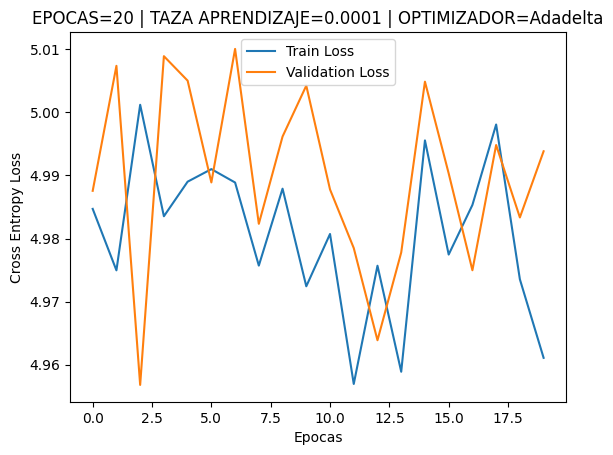

In [68]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------Adagrad--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 1.5213
Epoch [1/5]	Validation	Loss: 0.5152	Validation Accuracy: 78.0%
Epoch [2/5]	Training [40%]	Loss: 0.9807
Epoch [2/5]	Validation	Loss: 0.6217	Validation Accuracy: 71.5%
Epoch [3/5]	Training [60%]	Loss: 1.1363
Epoch [3/5]	Validation	Loss: 0.6908	Validation Accuracy: 69.0%
Epoch [4/5]	Training [80%]	Loss: 0.9130
Epoch [4/5]	Validation	Loss: 0.7800	Validation Accuracy: 66.0%
Epoch [5/5]	Training [100%]	Loss: 0.8952
Epoch [5/5]	Validation	Loss: 0.6951	Validation Accuracy: 68.5%
Performance on the test data:
	Loss: 0.6951
	Accuracy: 68.5%
	precision: 80.7%
	recall: 68.5%
	f_score: 65.0%
(0.8067484662576687, 0.685, 0.6503011295828592, None)

Confusion Matrix:
[[100   0]
 [ 63  37]]


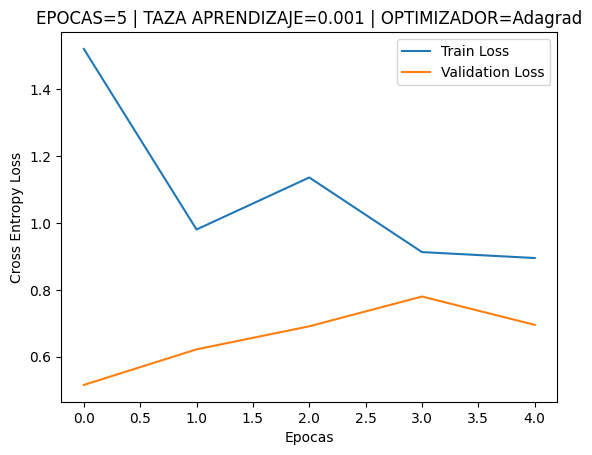

In [69]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 1.7036
Epoch [1/10]	Validation	Loss: 0.5851	Validation Accuracy: 74.5%
Epoch [2/10]	Training [20%]	Loss: 1.1508
Epoch [2/10]	Validation	Loss: 0.7170	Validation Accuracy: 70.0%
Epoch [3/10]	Training [30%]	Loss: 0.8811
Epoch [3/10]	Validation	Loss: 0.5327	Validation Accuracy: 77.0%
Epoch [4/10]	Training [40%]	Loss: 1.0807
Epoch [4/10]	Validation	Loss: 0.7128	Validation Accuracy: 71.0%
Epoch [5/10]	Training [50%]	Loss: 0.8337
Epoch [5/10]	Validation	Loss: 0.5897	Validation Accuracy: 74.5%
Epoch [6/10]	Training [60%]	Loss: 0.9574
Epoch [6/10]	Validation	Loss: 0.5210	Validation Accuracy: 77.0%
Epoch [7/10]	Training [70%]	Loss: 0.8066
Epoch [7/10]	Validation	Loss: 0.6856	Validation Accuracy: 69.5%
Epoch [8/10]	Training [80%]	Loss: 0.8269
Epoch [8/10]	Validation	Loss: 0.7316	Validation Accuracy: 69.0%
Epoch [9/10]	Training [90%]	Loss: 0.8656
Epoch [9/10]	Validation	Loss: 0.8969	Validation Accuracy: 63.0%
Epoch [10/10]	Training [100%]	Loss: 0.8123
Epoch [10/10

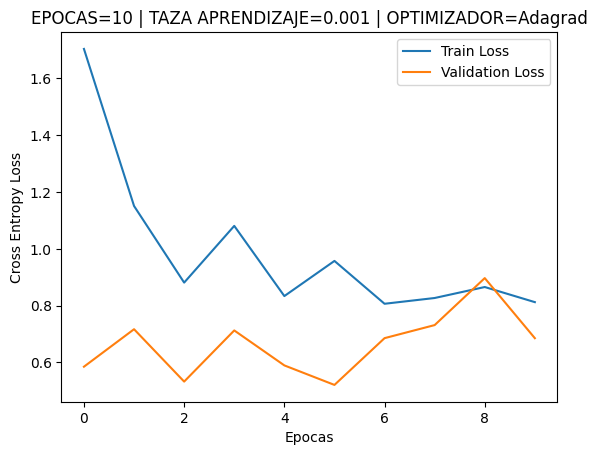

In [70]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 1.5616
Epoch [1/15]	Validation	Loss: 0.6841	Validation Accuracy: 72.5%
Epoch [2/15]	Training [13%]	Loss: 1.0475
Epoch [2/15]	Validation	Loss: 0.7346	Validation Accuracy: 70.5%
Epoch [3/15]	Training [20%]	Loss: 1.0883
Epoch [3/15]	Validation	Loss: 0.5551	Validation Accuracy: 75.0%
Epoch [4/15]	Training [27%]	Loss: 0.9280
Epoch [4/15]	Validation	Loss: 0.6675	Validation Accuracy: 72.5%
Epoch [5/15]	Training [33%]	Loss: 0.9960
Epoch [5/15]	Validation	Loss: 0.5262	Validation Accuracy: 77.0%
Epoch [6/15]	Training [40%]	Loss: 0.9718
Epoch [6/15]	Validation	Loss: 1.0359	Validation Accuracy: 61.0%
Epoch [7/15]	Training [47%]	Loss: 0.8844
Epoch [7/15]	Validation	Loss: 0.6316	Validation Accuracy: 73.0%
Epoch [8/15]	Training [53%]	Loss: 0.7683
Epoch [8/15]	Validation	Loss: 0.5453	Validation Accuracy: 77.0%
Epoch [9/15]	Training [60%]	Loss: 0.8370
Epoch [9/15]	Validation	Loss: 0.9321	Validation Accuracy: 64.0%
Epoch [10/15]	Training [67%]	Loss: 0.8416
Epoch [10/15]	

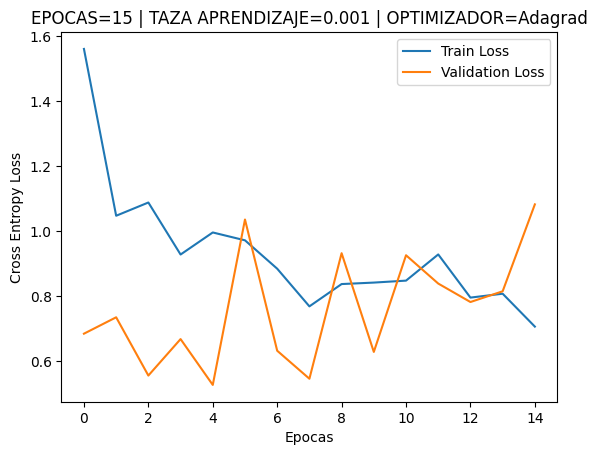

In [71]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 1.9297
Epoch [1/20]	Validation	Loss: 0.8579	Validation Accuracy: 68.0%
Epoch [2/20]	Training [10%]	Loss: 1.3568
Epoch [2/20]	Validation	Loss: 0.9174	Validation Accuracy: 68.0%
Epoch [3/20]	Training [15%]	Loss: 1.2956
Epoch [3/20]	Validation	Loss: 1.0203	Validation Accuracy: 64.0%
Epoch [4/20]	Training [20%]	Loss: 1.0692
Epoch [4/20]	Validation	Loss: 0.8436	Validation Accuracy: 68.0%
Epoch [5/20]	Training [25%]	Loss: 1.0971
Epoch [5/20]	Validation	Loss: 0.6803	Validation Accuracy: 72.5%
Epoch [6/20]	Training [30%]	Loss: 0.9847
Epoch [6/20]	Validation	Loss: 0.8920	Validation Accuracy: 65.5%
Epoch [7/20]	Training [35%]	Loss: 0.9387
Epoch [7/20]	Validation	Loss: 0.6283	Validation Accuracy: 75.0%
Epoch [8/20]	Training [40%]	Loss: 1.0420
Epoch [8/20]	Validation	Loss: 0.7815	Validation Accuracy: 68.5%
Epoch [9/20]	Training [45%]	Loss: 1.0055
Epoch [9/20]	Validation	Loss: 0.7547	Validation Accuracy: 69.0%
Epoch [10/20]	Training [50%]	Loss: 0.8531
Epoch [10/20]	

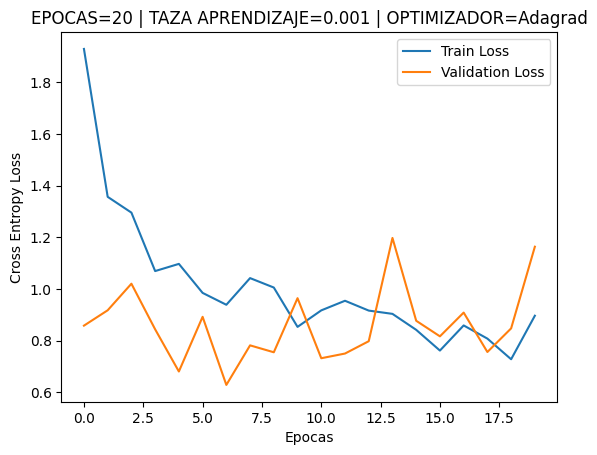

In [72]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 4.4055
Epoch [1/5]	Validation	Loss: 4.6639	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 5.0522
Epoch [2/5]	Validation	Loss: 4.9335	Validation Accuracy: 52.5%
Epoch [3/5]	Training [60%]	Loss: 4.4992
Epoch [3/5]	Validation	Loss: 4.7718	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 5.0128
Epoch [4/5]	Validation	Loss: 5.6515	Validation Accuracy: 51.5%
Epoch [5/5]	Training [100%]	Loss: 4.9336
Epoch [5/5]	Validation	Loss: 5.5113	Validation Accuracy: 49.0%
Performance on the test data:
	Loss: 5.5113
	Accuracy: 49.0%
	precision: 24.7%
	recall: 49.0%
	f_score: 32.9%
(0.2474747474747475, 0.49, 0.32885906040268453, None)

Confusion Matrix:
[[ 98   2]
 [100   0]]


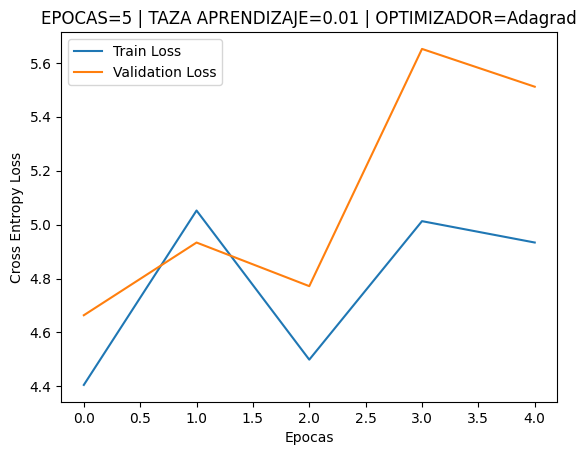

In [73]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 4.4840
Epoch [1/10]	Validation	Loss: 6.9191	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 3.3031
Epoch [2/10]	Validation	Loss: 2.6015	Validation Accuracy: 47.0%
Epoch [3/10]	Training [30%]	Loss: 2.4965
Epoch [3/10]	Validation	Loss: 2.7931	Validation Accuracy: 53.5%
Epoch [4/10]	Training [40%]	Loss: 2.4486
Epoch [4/10]	Validation	Loss: 2.6726	Validation Accuracy: 46.5%
Epoch [5/10]	Training [50%]	Loss: 2.5693
Epoch [5/10]	Validation	Loss: 2.7963	Validation Accuracy: 44.5%
Epoch [6/10]	Training [60%]	Loss: 2.1652
Epoch [6/10]	Validation	Loss: 2.7965	Validation Accuracy: 52.5%
Epoch [7/10]	Training [70%]	Loss: 2.5045
Epoch [7/10]	Validation	Loss: 2.5686	Validation Accuracy: 54.5%
Epoch [8/10]	Training [80%]	Loss: 2.3210
Epoch [8/10]	Validation	Loss: 2.5044	Validation Accuracy: 51.0%
Epoch [9/10]	Training [90%]	Loss: 2.3181
Epoch [9/10]	Validation	Loss: 2.4598	Validation Accuracy: 51.5%
Epoch [10/10]	Training [100%]	Loss: 1.8671
Epoch [10/10

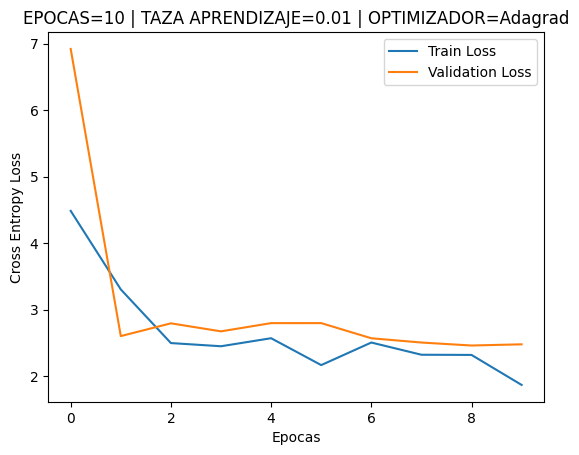

In [74]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 4.9247
Epoch [1/15]	Validation	Loss: 5.0345	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 4.6461
Epoch [2/15]	Validation	Loss: 4.7993	Validation Accuracy: 54.0%
Epoch [3/15]	Training [20%]	Loss: 5.0812
Epoch [3/15]	Validation	Loss: 4.2166	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 4.7271
Epoch [4/15]	Validation	Loss: 3.5406	Validation Accuracy: 48.5%
Epoch [5/15]	Training [33%]	Loss: 4.4078
Epoch [5/15]	Validation	Loss: 5.4331	Validation Accuracy: 49.0%
Epoch [6/15]	Training [40%]	Loss: 4.5390
Epoch [6/15]	Validation	Loss: 4.6739	Validation Accuracy: 51.0%
Epoch [7/15]	Training [47%]	Loss: 4.2607
Epoch [7/15]	Validation	Loss: 4.9106	Validation Accuracy: 49.0%
Epoch [8/15]	Training [53%]	Loss: 4.3227
Epoch [8/15]	Validation	Loss: 5.0264	Validation Accuracy: 49.5%
Epoch [9/15]	Training [60%]	Loss: 3.8019
Epoch [9/15]	Validation	Loss: 4.4267	Validation Accuracy: 51.0%
Epoch [10/15]	Training [67%]	Loss: 4.2582
Epoch [10/15]	

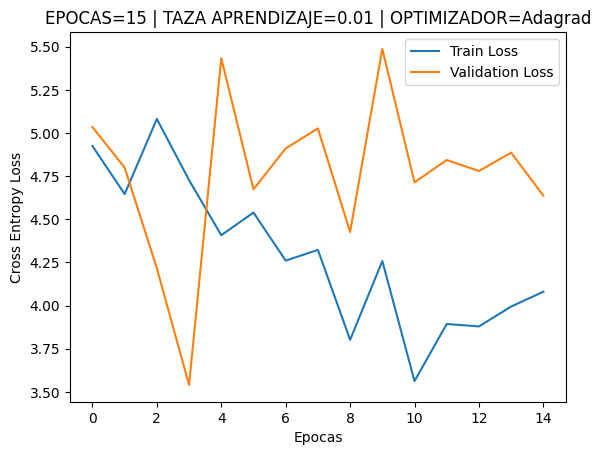

In [75]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 1.8404
Epoch [1/20]	Validation	Loss: 0.5991	Validation Accuracy: 67.0%
Epoch [2/20]	Training [10%]	Loss: 0.7015
Epoch [2/20]	Validation	Loss: 0.6125	Validation Accuracy: 74.0%
Epoch [3/20]	Training [15%]	Loss: 0.5651
Epoch [3/20]	Validation	Loss: 0.4623	Validation Accuracy: 85.0%
Epoch [4/20]	Training [20%]	Loss: 0.4900
Epoch [4/20]	Validation	Loss: 0.6521	Validation Accuracy: 75.5%
Epoch [5/20]	Training [25%]	Loss: 0.4548
Epoch [5/20]	Validation	Loss: 0.6290	Validation Accuracy: 77.0%
Epoch [6/20]	Training [30%]	Loss: 0.4701
Epoch [6/20]	Validation	Loss: 0.4583	Validation Accuracy: 83.0%
Epoch [7/20]	Training [35%]	Loss: 0.3962
Epoch [7/20]	Validation	Loss: 0.5375	Validation Accuracy: 81.5%
Epoch [8/20]	Training [40%]	Loss: 0.4144
Epoch [8/20]	Validation	Loss: 0.4635	Validation Accuracy: 82.0%
Epoch [9/20]	Training [45%]	Loss: 0.3728
Epoch [9/20]	Validation	Loss: 0.3783	Validation Accuracy: 85.0%
Epoch [10/20]	Training [50%]	Loss: 0.3626
Epoch [10/20]	

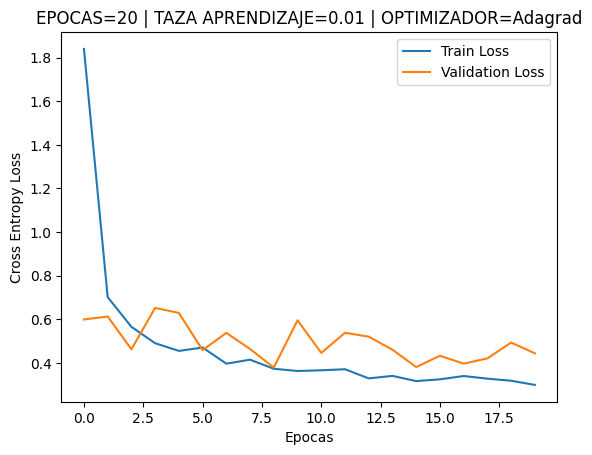

In [76]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 4.8504
Epoch [1/5]	Validation	Loss: 4.5608	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 4.0531
Epoch [2/5]	Validation	Loss: 3.4637	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 2.9872
Epoch [3/5]	Validation	Loss: 2.0763	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 1.7739
Epoch [4/5]	Validation	Loss: 1.2273	Validation Accuracy: 59.5%
Epoch [5/5]	Training [100%]	Loss: 1.3321
Epoch [5/5]	Validation	Loss: 0.9310	Validation Accuracy: 65.5%
Performance on the test data:
	Loss: 0.9310
	Accuracy: 65.5%
	precision: 79.6%
	recall: 65.5%
	f_score: 60.8%
(0.7958579881656804, 0.655, 0.6083884332699566, None)

Confusion Matrix:
[[100   0]
 [ 69  31]]


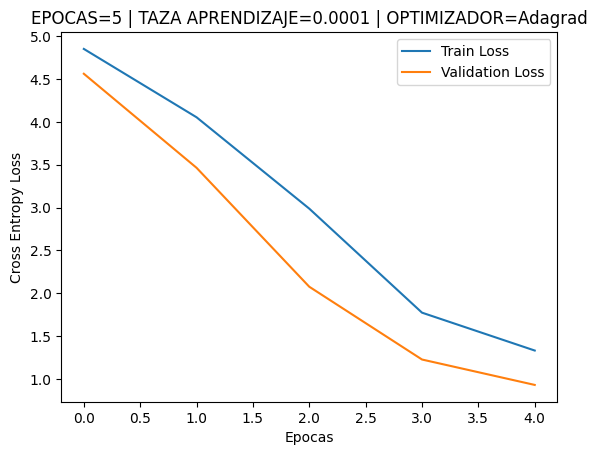

In [77]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 4.8837
Epoch [1/10]	Validation	Loss: 4.6846	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 4.1968
Epoch [2/10]	Validation	Loss: 3.4000	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 2.9001
Epoch [3/10]	Validation	Loss: 1.6723	Validation Accuracy: 53.0%
Epoch [4/10]	Training [40%]	Loss: 1.4911
Epoch [4/10]	Validation	Loss: 0.8977	Validation Accuracy: 65.5%
Epoch [5/10]	Training [50%]	Loss: 1.3317
Epoch [5/10]	Validation	Loss: 0.6815	Validation Accuracy: 73.0%
Epoch [6/10]	Training [60%]	Loss: 1.3028
Epoch [6/10]	Validation	Loss: 0.6091	Validation Accuracy: 75.0%
Epoch [7/10]	Training [70%]	Loss: 1.1914
Epoch [7/10]	Validation	Loss: 0.5860	Validation Accuracy: 76.0%
Epoch [8/10]	Training [80%]	Loss: 1.0762
Epoch [8/10]	Validation	Loss: 0.5812	Validation Accuracy: 76.0%
Epoch [9/10]	Training [90%]	Loss: 1.4096
Epoch [9/10]	Validation	Loss: 0.6093	Validation Accuracy: 74.5%
Epoch [10/10]	Training [100%]	Loss: 1.1729
Epoch [10/10

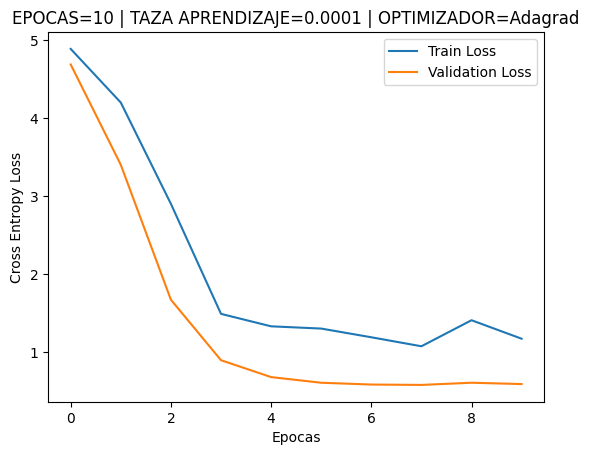

In [78]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 4.9916
Epoch [1/15]	Validation	Loss: 4.9213	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 4.6799
Epoch [2/15]	Validation	Loss: 4.3603	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 3.7834
Epoch [3/15]	Validation	Loss: 3.1643	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 2.7553
Epoch [4/15]	Validation	Loss: 1.9172	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 1.9714
Epoch [5/15]	Validation	Loss: 1.3730	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 1.5837
Epoch [6/15]	Validation	Loss: 1.1908	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 1.6183
Epoch [7/15]	Validation	Loss: 1.1444	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 1.6183
Epoch [8/15]	Validation	Loss: 1.1441	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 1.5873
Epoch [9/15]	Validation	Loss: 1.0965	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 1.6022
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


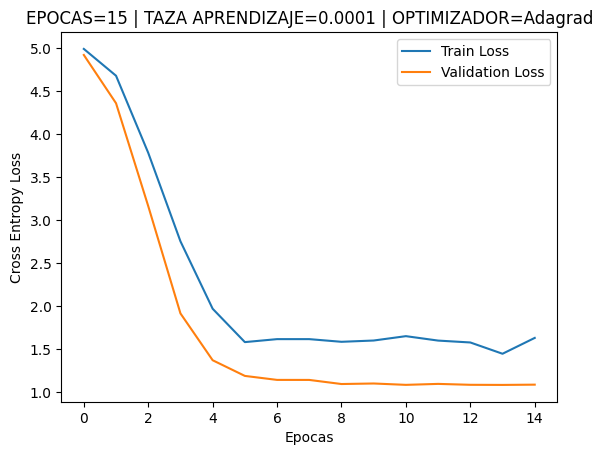

In [79]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 4.9740
Epoch [1/20]	Validation	Loss: 4.9105	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 4.8194
Epoch [2/20]	Validation	Loss: 4.5143	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 3.9043
Epoch [3/20]	Validation	Loss: 3.0992	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 2.4687
Epoch [4/20]	Validation	Loss: 1.5834	Validation Accuracy: 56.5%
Epoch [5/20]	Training [25%]	Loss: 1.6108
Epoch [5/20]	Validation	Loss: 0.9489	Validation Accuracy: 67.0%
Epoch [6/20]	Training [30%]	Loss: 1.4267
Epoch [6/20]	Validation	Loss: 0.7762	Validation Accuracy: 69.0%
Epoch [7/20]	Training [35%]	Loss: 1.3798
Epoch [7/20]	Validation	Loss: 0.6766	Validation Accuracy: 71.0%
Epoch [8/20]	Training [40%]	Loss: 1.1085
Epoch [8/20]	Validation	Loss: 0.6445	Validation Accuracy: 73.5%
Epoch [9/20]	Training [45%]	Loss: 1.3078
Epoch [9/20]	Validation	Loss: 0.6491	Validation Accuracy: 72.0%
Epoch [10/20]	Training [50%]	Loss: 1.2246
Epoch [10/20]	

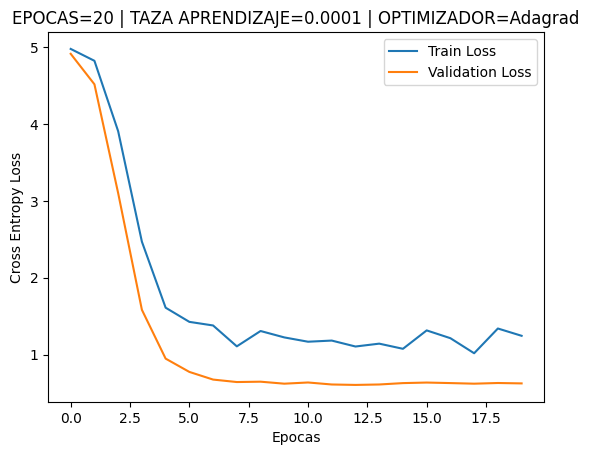

In [80]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------RMSprop--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 1.7666
Epoch [1/5]	Validation	Loss: 0.8289	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.9568
Epoch [2/5]	Validation	Loss: 0.7901	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.8169
Epoch [3/5]	Validation	Loss: 0.6600	Validation Accuracy: 68.5%
Epoch [4/5]	Training [80%]	Loss: 0.7425
Epoch [4/5]	Validation	Loss: 0.7616	Validation Accuracy: 49.0%
Epoch [5/5]	Training [100%]	Loss: 0.6397
Epoch [5/5]	Validation	Loss: 0.5128	Validation Accuracy: 79.0%
Performance on the test data:
	Loss: 0.5128
	Accuracy: 79.0%
	precision: 80.0%
	recall: 79.0%
	f_score: 78.8%
(0.7997106242248864, 0.79, 0.7882851093860268, None)

Confusion Matrix:
[[70 30]
 [12 88]]


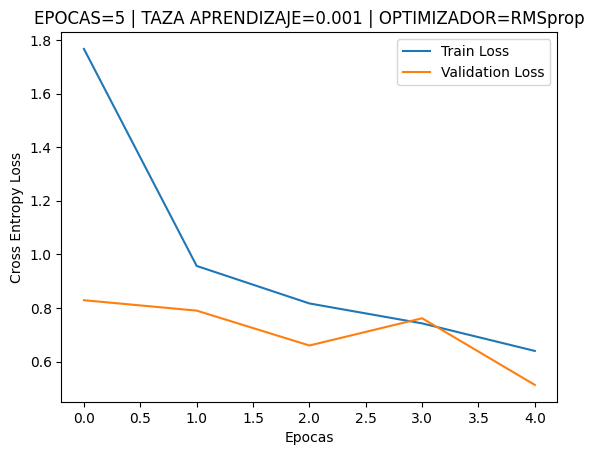

In [81]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 5.1363
Epoch [1/10]	Validation	Loss: 5.4574	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 5.4306
Epoch [2/10]	Validation	Loss: 5.4921	Validation Accuracy: 51.0%
Epoch [3/10]	Training [30%]	Loss: 4.8311
Epoch [3/10]	Validation	Loss: 4.9479	Validation Accuracy: 49.0%
Epoch [4/10]	Training [40%]	Loss: 4.7450
Epoch [4/10]	Validation	Loss: 5.0972	Validation Accuracy: 49.5%
Epoch [5/10]	Training [50%]	Loss: 4.8620
Epoch [5/10]	Validation	Loss: 4.8307	Validation Accuracy: 49.0%
Epoch [6/10]	Training [60%]	Loss: 4.5558
Epoch [6/10]	Validation	Loss: 4.9322	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 5.2008
Epoch [7/10]	Validation	Loss: 4.9872	Validation Accuracy: 49.5%
Epoch [8/10]	Training [80%]	Loss: 5.1077
Epoch [8/10]	Validation	Loss: 4.9375	Validation Accuracy: 51.0%
Epoch [9/10]	Training [90%]	Loss: 4.7646
Epoch [9/10]	Validation	Loss: 4.7484	Validation Accuracy: 49.5%
Epoch [10/10]	Training [100%]	Loss: 4.6013
Epoch [10/10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


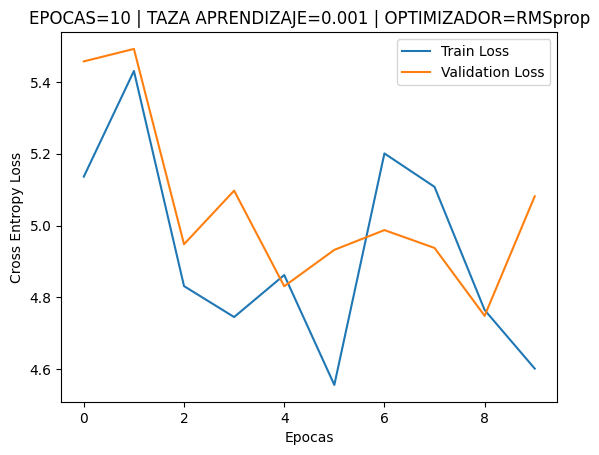

In [82]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 2.1904
Epoch [1/15]	Validation	Loss: 4.9891	Validation Accuracy: 51.0%
Epoch [2/15]	Training [13%]	Loss: 4.6321
Epoch [2/15]	Validation	Loss: 5.3615	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 4.9383
Epoch [3/15]	Validation	Loss: 5.1677	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 4.7106
Epoch [4/15]	Validation	Loss: 4.8542	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 4.7930
Epoch [5/15]	Validation	Loss: 5.5149	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 4.6613
Epoch [6/15]	Validation	Loss: 5.2067	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 4.6043
Epoch [7/15]	Validation	Loss: 4.3317	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 3.5445
Epoch [8/15]	Validation	Loss: 4.3521	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 3.0293
Epoch [9/15]	Validation	Loss: 0.7750	Validation Accuracy: 44.5%
Epoch [10/15]	Training [67%]	Loss: 1.0101
Epoch [10/15]	

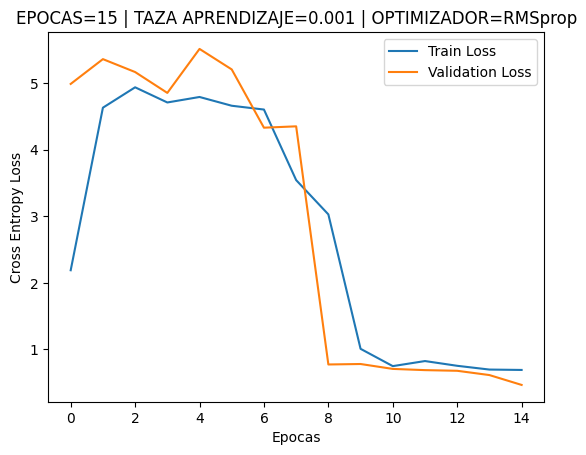

In [83]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 2.0378
Epoch [1/20]	Validation	Loss: 0.8202	Validation Accuracy: 51.5%
Epoch [2/20]	Training [10%]	Loss: 0.9748
Epoch [2/20]	Validation	Loss: 0.8303	Validation Accuracy: 49.5%
Epoch [3/20]	Training [15%]	Loss: 0.7262
Epoch [3/20]	Validation	Loss: 0.5750	Validation Accuracy: 72.0%
Epoch [4/20]	Training [20%]	Loss: 0.6436
Epoch [4/20]	Validation	Loss: 0.5294	Validation Accuracy: 80.5%
Epoch [5/20]	Training [25%]	Loss: 0.5082
Epoch [5/20]	Validation	Loss: 0.6732	Validation Accuracy: 78.5%
Epoch [6/20]	Training [30%]	Loss: 0.5018
Epoch [6/20]	Validation	Loss: 0.4487	Validation Accuracy: 83.5%
Epoch [7/20]	Training [35%]	Loss: 0.4979
Epoch [7/20]	Validation	Loss: 0.4521	Validation Accuracy: 80.5%
Epoch [8/20]	Training [40%]	Loss: 0.3993
Epoch [8/20]	Validation	Loss: 0.3733	Validation Accuracy: 85.5%
Epoch [9/20]	Training [45%]	Loss: 0.3296
Epoch [9/20]	Validation	Loss: 0.4192	Validation Accuracy: 85.0%
Epoch [10/20]	Training [50%]	Loss: 0.4031
Epoch [10/20]	

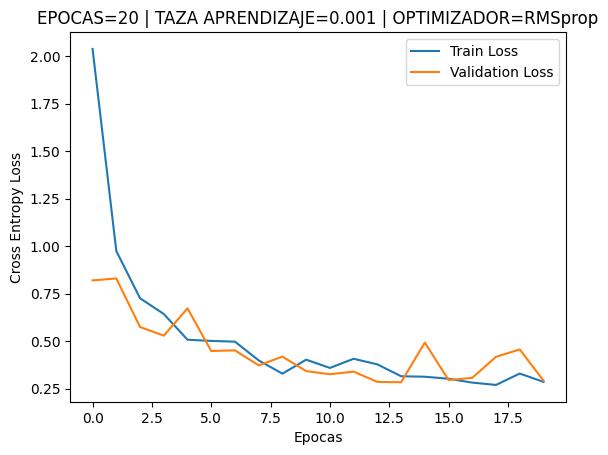

In [84]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 2.2613
Epoch [1/5]	Validation	Loss: 0.8939	Validation Accuracy: 55.5%
Epoch [2/5]	Training [40%]	Loss: 3.2713
Epoch [2/5]	Validation	Loss: 5.4795	Validation Accuracy: 51.0%
Epoch [3/5]	Training [60%]	Loss: 3.0308
Epoch [3/5]	Validation	Loss: 4.9994	Validation Accuracy: 49.0%
Epoch [4/5]	Training [80%]	Loss: 2.9755
Epoch [4/5]	Validation	Loss: 4.3072	Validation Accuracy: 52.0%
Epoch [5/5]	Training [100%]	Loss: 5.1460
Epoch [5/5]	Validation	Loss: 5.3587	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 5.3587
	Accuracy: 50.0%
	precision: 50.0%
	recall: 50.0%
	f_score: 35.8%
(0.5, 0.5, 0.35823385958156845, None)

Confusion Matrix:
[[97  3]
 [97  3]]


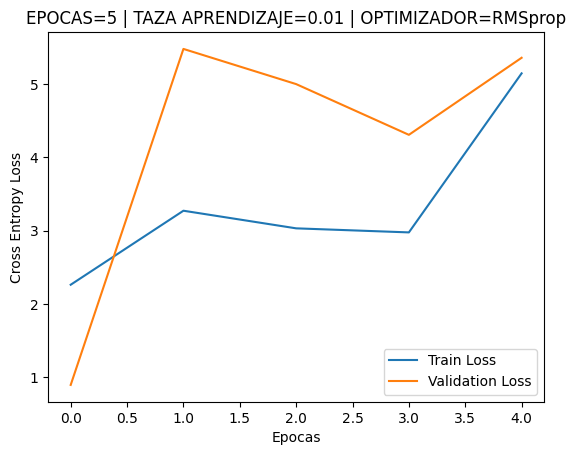

In [85]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 5.0367
Epoch [1/10]	Validation	Loss: 9.0658	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 4.9681
Epoch [2/10]	Validation	Loss: 10.0839	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 4.7498
Epoch [3/10]	Validation	Loss: 8.1667	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 5.4619
Epoch [4/10]	Validation	Loss: 3.4349	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 4.7060
Epoch [5/10]	Validation	Loss: 4.7073	Validation Accuracy: 48.5%
Epoch [6/10]	Training [60%]	Loss: 4.8871
Epoch [6/10]	Validation	Loss: 5.0608	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 4.4898
Epoch [7/10]	Validation	Loss: 4.9088	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 3.8667
Epoch [8/10]	Validation	Loss: 5.1679	Validation Accuracy: 48.5%
Epoch [9/10]	Training [90%]	Loss: 4.1937
Epoch [9/10]	Validation	Loss: 4.7407	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 1.7365
Epoch [10/1

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


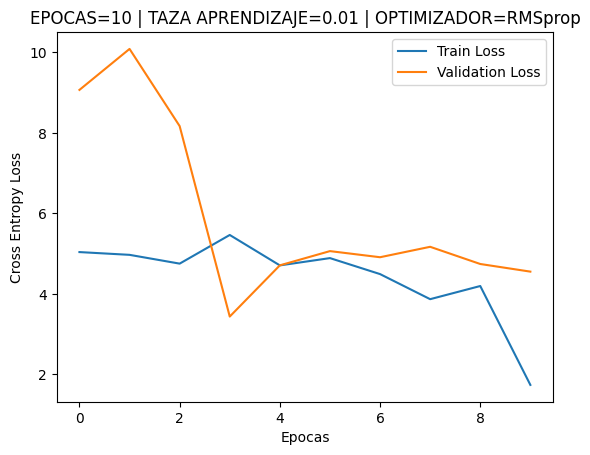

In [86]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 5.0783
Epoch [1/15]	Validation	Loss: 4.7459	Validation Accuracy: 51.0%
Epoch [2/15]	Training [13%]	Loss: 4.6997
Epoch [2/15]	Validation	Loss: 5.3344	Validation Accuracy: 50.5%
Epoch [3/15]	Training [20%]	Loss: 4.6352
Epoch [3/15]	Validation	Loss: 4.8906	Validation Accuracy: 52.5%
Epoch [4/15]	Training [27%]	Loss: 4.7911
Epoch [4/15]	Validation	Loss: 4.7448	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 5.0260
Epoch [5/15]	Validation	Loss: 4.4584	Validation Accuracy: 49.5%
Epoch [6/15]	Training [40%]	Loss: 5.2083
Epoch [6/15]	Validation	Loss: 4.9118	Validation Accuracy: 51.5%
Epoch [7/15]	Training [47%]	Loss: 4.4296
Epoch [7/15]	Validation	Loss: 5.1298	Validation Accuracy: 48.5%
Epoch [8/15]	Training [53%]	Loss: 4.7190
Epoch [8/15]	Validation	Loss: 5.0214	Validation Accuracy: 48.5%
Epoch [9/15]	Training [60%]	Loss: 5.4299
Epoch [9/15]	Validation	Loss: 5.2201	Validation Accuracy: 48.0%
Epoch [10/15]	Training [67%]	Loss: 4.9230
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


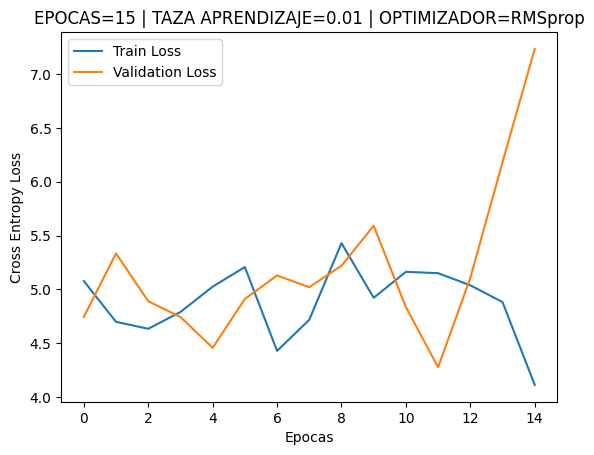

In [87]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 4.8767
Epoch [1/20]	Validation	Loss: 4.7999	Validation Accuracy: 50.5%
Epoch [2/20]	Training [10%]	Loss: 5.2020
Epoch [2/20]	Validation	Loss: 5.9400	Validation Accuracy: 51.0%
Epoch [3/20]	Training [15%]	Loss: 4.5918
Epoch [3/20]	Validation	Loss: 5.3030	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 4.5899
Epoch [4/20]	Validation	Loss: 5.2174	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 3.4263
Epoch [5/20]	Validation	Loss: 2.1463	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 2.1644
Epoch [6/20]	Validation	Loss: 1.9421	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 1.9959
Epoch [7/20]	Validation	Loss: 4.5978	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 2.7010
Epoch [8/20]	Validation	Loss: 4.0836	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 2.1629
Epoch [9/20]	Validation	Loss: 1.3868	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 2.0329
Epoch [10/20]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


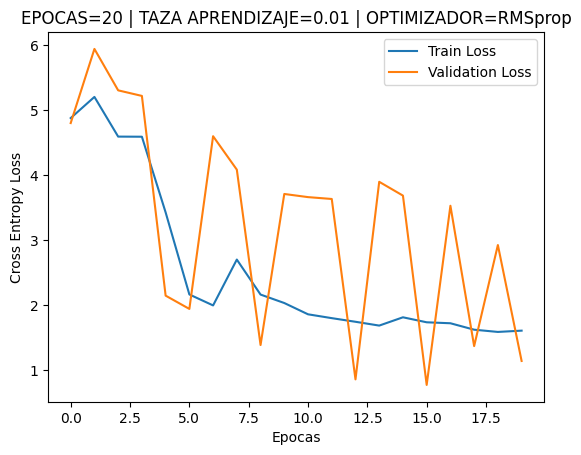

In [88]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 1.6753
Epoch [1/5]	Validation	Loss: 0.5901	Validation Accuracy: 72.0%
Epoch [2/5]	Training [40%]	Loss: 1.2858
Epoch [2/5]	Validation	Loss: 0.7630	Validation Accuracy: 70.0%
Epoch [3/5]	Training [60%]	Loss: 1.0149
Epoch [3/5]	Validation	Loss: 0.5276	Validation Accuracy: 75.5%
Epoch [4/5]	Training [80%]	Loss: 1.1780
Epoch [4/5]	Validation	Loss: 0.6997	Validation Accuracy: 69.5%
Epoch [5/5]	Training [100%]	Loss: 1.0220
Epoch [5/5]	Validation	Loss: 0.8281	Validation Accuracy: 66.0%
Performance on the test data:
	Loss: 0.8281
	Accuracy: 66.0%
	precision: 79.8%
	recall: 66.0%
	f_score: 61.6%
(0.7976190476190477, 0.66, 0.6155585707824514, None)

Confusion Matrix:
[[100   0]
 [ 68  32]]


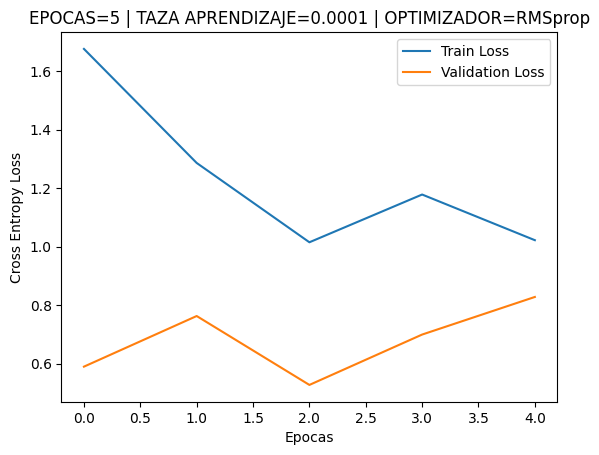

In [89]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 1.4882
Epoch [1/10]	Validation	Loss: 0.6603	Validation Accuracy: 72.0%
Epoch [2/10]	Training [20%]	Loss: 1.3143
Epoch [2/10]	Validation	Loss: 0.5915	Validation Accuracy: 74.0%
Epoch [3/10]	Training [30%]	Loss: 1.1092
Epoch [3/10]	Validation	Loss: 0.5171	Validation Accuracy: 77.5%
Epoch [4/10]	Training [40%]	Loss: 0.9236
Epoch [4/10]	Validation	Loss: 0.5184	Validation Accuracy: 78.0%
Epoch [5/10]	Training [50%]	Loss: 0.8738
Epoch [5/10]	Validation	Loss: 0.5045	Validation Accuracy: 78.5%
Epoch [6/10]	Training [60%]	Loss: 0.8714
Epoch [6/10]	Validation	Loss: 0.6020	Validation Accuracy: 71.0%
Epoch [7/10]	Training [70%]	Loss: 0.8985
Epoch [7/10]	Validation	Loss: 0.5918	Validation Accuracy: 70.0%
Epoch [8/10]	Training [80%]	Loss: 0.7464
Epoch [8/10]	Validation	Loss: 0.8437	Validation Accuracy: 66.5%
Epoch [9/10]	Training [90%]	Loss: 0.7844
Epoch [9/10]	Validation	Loss: 0.9516	Validation Accuracy: 61.5%
Epoch [10/10]	Training [100%]	Loss: 0.8533
Epoch [10/10

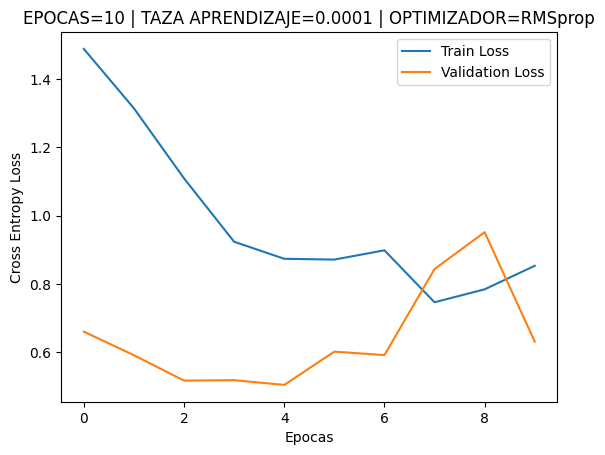

In [90]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 1.7948
Epoch [1/15]	Validation	Loss: 0.9309	Validation Accuracy: 67.5%
Epoch [2/15]	Training [13%]	Loss: 1.1412
Epoch [2/15]	Validation	Loss: 0.5762	Validation Accuracy: 76.0%
Epoch [3/15]	Training [20%]	Loss: 1.1079
Epoch [3/15]	Validation	Loss: 0.8040	Validation Accuracy: 69.0%
Epoch [4/15]	Training [27%]	Loss: 1.0670
Epoch [4/15]	Validation	Loss: 0.7741	Validation Accuracy: 69.0%
Epoch [5/15]	Training [33%]	Loss: 1.1527
Epoch [5/15]	Validation	Loss: 0.6636	Validation Accuracy: 71.0%
Epoch [6/15]	Training [40%]	Loss: 1.1085
Epoch [6/15]	Validation	Loss: 1.1008	Validation Accuracy: 59.5%
Epoch [7/15]	Training [47%]	Loss: 1.0036
Epoch [7/15]	Validation	Loss: 1.1252	Validation Accuracy: 59.5%
Epoch [8/15]	Training [53%]	Loss: 0.8616
Epoch [8/15]	Validation	Loss: 1.9883	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 0.8436
Epoch [9/15]	Validation	Loss: 1.8898	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 0.7794
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


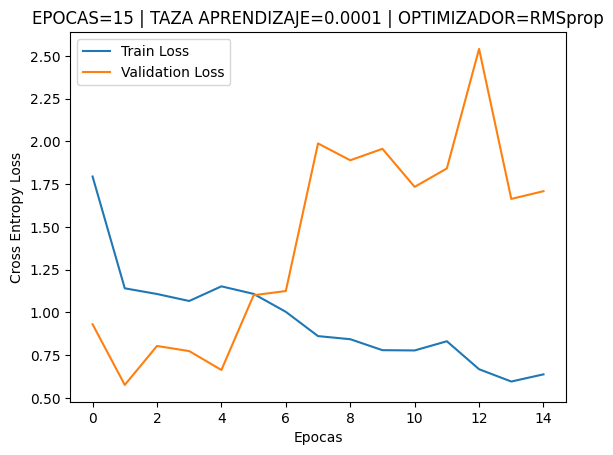

In [91]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 1.7541
Epoch [1/20]	Validation	Loss: 0.7022	Validation Accuracy: 72.0%
Epoch [2/20]	Training [10%]	Loss: 1.1888
Epoch [2/20]	Validation	Loss: 0.6124	Validation Accuracy: 70.0%
Epoch [3/20]	Training [15%]	Loss: 1.0204
Epoch [3/20]	Validation	Loss: 0.5362	Validation Accuracy: 73.5%
Epoch [4/20]	Training [20%]	Loss: 1.0725
Epoch [4/20]	Validation	Loss: 0.5651	Validation Accuracy: 74.0%
Epoch [5/20]	Training [25%]	Loss: 1.0366
Epoch [5/20]	Validation	Loss: 0.5424	Validation Accuracy: 75.0%
Epoch [6/20]	Training [30%]	Loss: 0.8907
Epoch [6/20]	Validation	Loss: 0.5956	Validation Accuracy: 71.5%
Epoch [7/20]	Training [35%]	Loss: 1.0149
Epoch [7/20]	Validation	Loss: 0.5740	Validation Accuracy: 71.5%
Epoch [8/20]	Training [40%]	Loss: 0.8103
Epoch [8/20]	Validation	Loss: 0.5659	Validation Accuracy: 72.0%
Epoch [9/20]	Training [45%]	Loss: 0.9550
Epoch [9/20]	Validation	Loss: 0.9774	Validation Accuracy: 56.0%
Epoch [10/20]	Training [50%]	Loss: 0.8920
Epoch [10/20]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


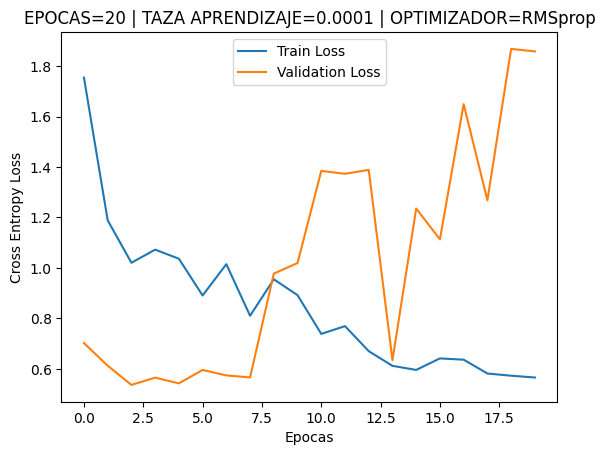

In [92]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------LBFGS--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 5.4862
Epoch [1/5]	Validation	Loss: 4.9833	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.0001
Epoch [2/5]	Validation	Loss: 4.9959	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 10.2760
Epoch [3/5]	Validation	Loss: 4.9837	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 0.0001
Epoch [4/5]	Validation	Loss: 4.9587	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 0.0001
Epoch [5/5]	Validation	Loss: 4.9802	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 4.9802
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


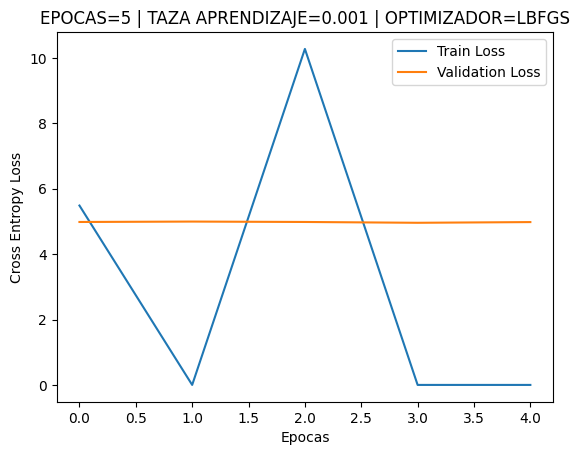

In [93]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 9.7241
Epoch [1/10]	Validation	Loss: 5.0325	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 0.0001
Epoch [2/10]	Validation	Loss: 5.0036	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 0.0000
Epoch [3/10]	Validation	Loss: 4.9859	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 0.0001
Epoch [4/10]	Validation	Loss: 4.9983	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 0.0001
Epoch [5/10]	Validation	Loss: 4.9736	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 9.7001
Epoch [6/10]	Validation	Loss: 5.0201	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 10.5040
Epoch [7/10]	Validation	Loss: 5.0404	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 9.3481
Epoch [8/10]	Validation	Loss: 5.0325	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 0.0000
Epoch [9/10]	Validation	Loss: 4.9952	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 9.7401
Epoch [10/1

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


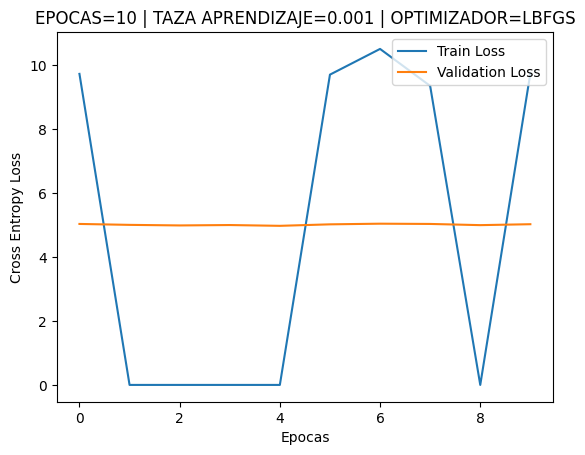

In [94]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 9.7001
Epoch [1/15]	Validation	Loss: 4.9910	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 9.9620
Epoch [2/15]	Validation	Loss: 5.0048	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 10.0580
Epoch [3/15]	Validation	Loss: 4.9813	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 10.2380
Epoch [4/15]	Validation	Loss: 4.9765	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 10.2080
Epoch [5/15]	Validation	Loss: 4.9831	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 0.0001
Epoch [6/15]	Validation	Loss: 4.9942	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 9.8101
Epoch [7/15]	Validation	Loss: 4.9843	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 10.2260
Epoch [8/15]	Validation	Loss: 4.9744	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 10.5500
Epoch [9/15]	Validation	Loss: 4.9645	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 10.2520
Epoch [1

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


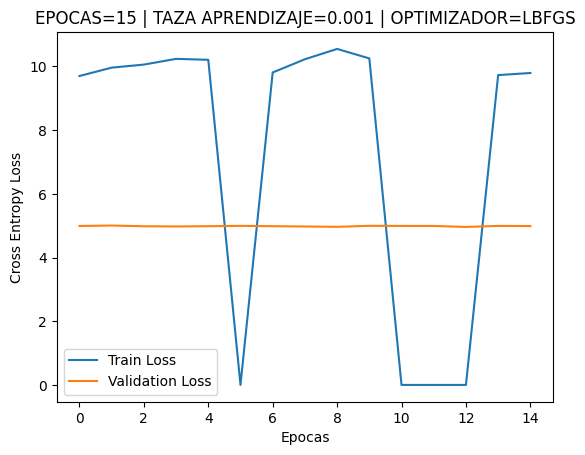

In [95]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 9.8441
Epoch [1/20]	Validation	Loss: 5.0036	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 0.0000
Epoch [2/20]	Validation	Loss: 5.0126	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.0000
Epoch [3/20]	Validation	Loss: 5.0279	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 0.0001
Epoch [4/20]	Validation	Loss: 5.0055	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 0.0000
Epoch [5/20]	Validation	Loss: 4.9719	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 9.8821
Epoch [6/20]	Validation	Loss: 5.0025	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 9.7481
Epoch [7/20]	Validation	Loss: 4.9816	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 9.9021
Epoch [8/20]	Validation	Loss: 4.9721	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 0.0001
Epoch [9/20]	Validation	Loss: 5.0033	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 10.1360
Epoch [10/20]

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


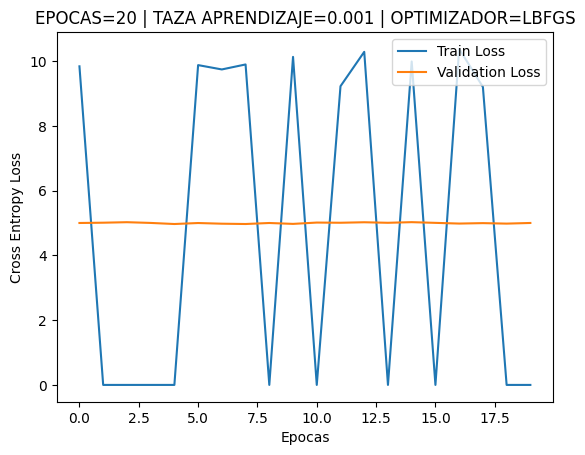

In [96]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 10.4620
Epoch [1/5]	Validation	Loss: 5.0019	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.0000
Epoch [2/5]	Validation	Loss: 4.9732	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.0000
Epoch [3/5]	Validation	Loss: 5.0092	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 9.6641
Epoch [4/5]	Validation	Loss: 4.9930	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 0.0001
Epoch [5/5]	Validation	Loss: 5.0086	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 5.0086
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


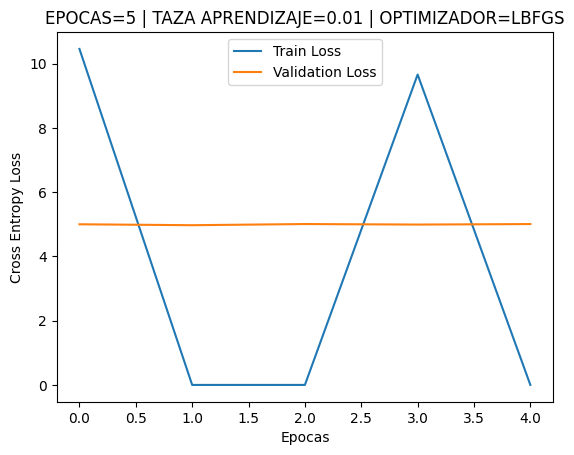

In [97]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.0000
Epoch [1/10]	Validation	Loss: 4.9776	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 10.1640
Epoch [2/10]	Validation	Loss: 4.9532	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 10.3540
Epoch [3/10]	Validation	Loss: 5.0125	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 9.9920
Epoch [4/10]	Validation	Loss: 4.9876	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 9.8461
Epoch [5/10]	Validation	Loss: 5.0084	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 9.6581
Epoch [6/10]	Validation	Loss: 4.9813	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 9.9120
Epoch [7/10]	Validation	Loss: 4.9986	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 10.2240
Epoch [8/10]	Validation	Loss: 5.0235	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 10.2500
Epoch [9/10]	Validation	Loss: 4.9762	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 9.5041
Epoch [1

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


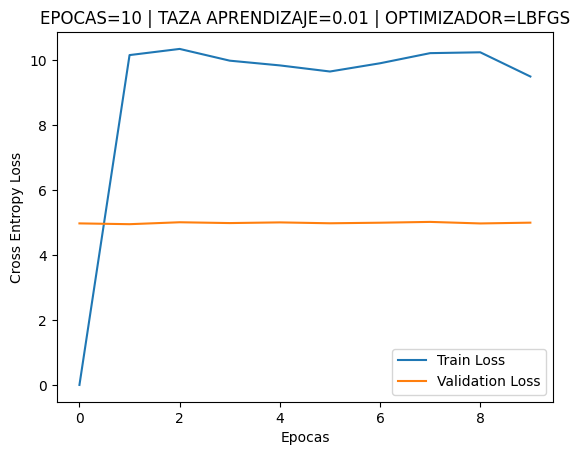

In [98]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.0000
Epoch [1/15]	Validation	Loss: 4.9981	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 0.0001
Epoch [2/15]	Validation	Loss: 4.9477	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 0.0001
Epoch [3/15]	Validation	Loss: 4.9872	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 0.0000
Epoch [4/15]	Validation	Loss: 4.9637	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 9.5281
Epoch [5/15]	Validation	Loss: 4.9526	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 0.0001
Epoch [6/15]	Validation	Loss: 5.0007	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 0.0000
Epoch [7/15]	Validation	Loss: 4.9736	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 10.2240
Epoch [8/15]	Validation	Loss: 4.9752	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 9.6721
Epoch [9/15]	Validation	Loss: 4.9813	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 9.6121
Epoch [10/15]

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


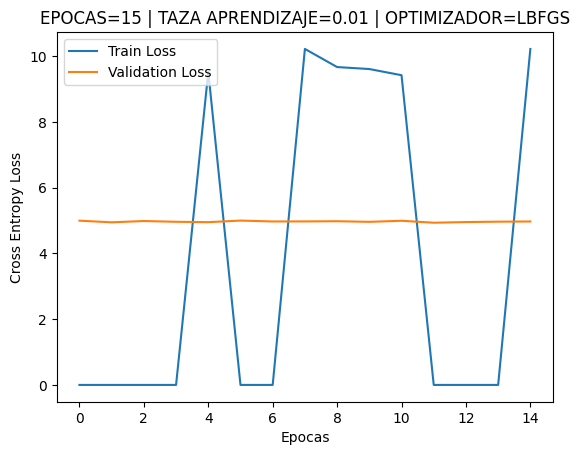

In [99]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 10.1940
Epoch [1/20]	Validation	Loss: 5.0258	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 9.9640
Epoch [2/20]	Validation	Loss: 4.9914	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.0000
Epoch [3/20]	Validation	Loss: 5.0091	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 10.1120
Epoch [4/20]	Validation	Loss: 4.9839	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 9.6921
Epoch [5/20]	Validation	Loss: 5.0285	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 0.0000
Epoch [6/20]	Validation	Loss: 4.9807	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 0.0001
Epoch [7/20]	Validation	Loss: 5.0255	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 9.7541
Epoch [8/20]	Validation	Loss: 5.0029	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 0.0000
Epoch [9/20]	Validation	Loss: 5.0609	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 0.0000
Epoch [10/20

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


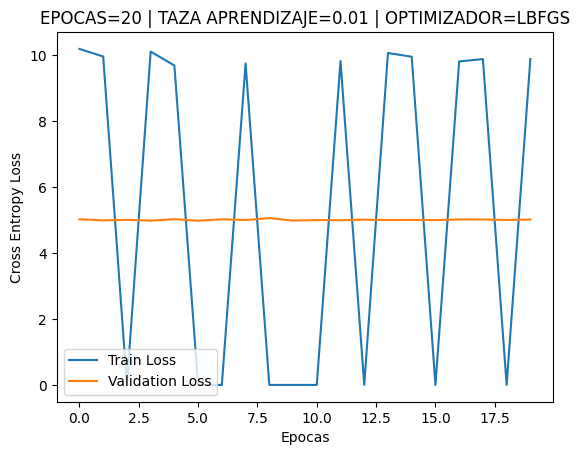

In [100]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.0000
Epoch [1/5]	Validation	Loss: 5.0082	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 10.3300
Epoch [2/5]	Validation	Loss: 4.9826	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 9.7201
Epoch [3/5]	Validation	Loss: 5.0200	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 9.6381
Epoch [4/5]	Validation	Loss: 4.9587	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 9.7861
Epoch [5/5]	Validation	Loss: 4.9879	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 4.9879
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


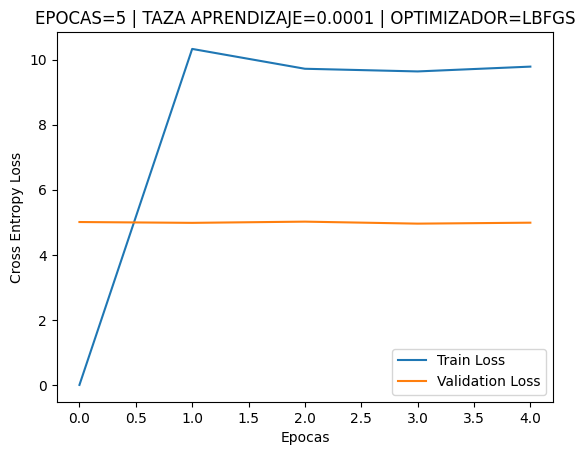

In [101]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.0001
Epoch [1/10]	Validation	Loss: 5.0131	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 0.0001
Epoch [2/10]	Validation	Loss: 5.0458	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 10.6280
Epoch [3/10]	Validation	Loss: 5.0502	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 0.0000
Epoch [4/10]	Validation	Loss: 5.0309	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 0.0001
Epoch [5/10]	Validation	Loss: 5.0515	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 0.0000
Epoch [6/10]	Validation	Loss: 4.9976	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 10.1640
Epoch [7/10]	Validation	Loss: 5.0257	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 9.6281
Epoch [8/10]	Validation	Loss: 5.0060	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 9.6241
Epoch [9/10]	Validation	Loss: 5.0355	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 10.2680
Epoch [10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


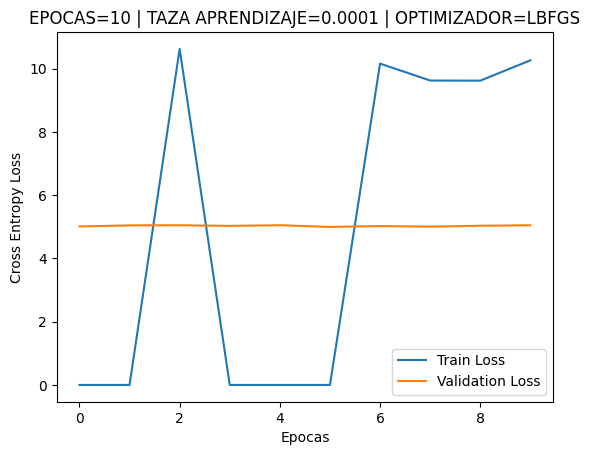

In [102]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 10.0420
Epoch [1/15]	Validation	Loss: 4.9582	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 10.2360
Epoch [2/15]	Validation	Loss: 4.9750	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 0.0001
Epoch [3/15]	Validation	Loss: 4.9818	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 10.2340
Epoch [4/15]	Validation	Loss: 4.9797	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 0.0001
Epoch [5/15]	Validation	Loss: 4.9990	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 0.0001
Epoch [6/15]	Validation	Loss: 4.9795	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 10.3280
Epoch [7/15]	Validation	Loss: 4.9827	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 0.0000
Epoch [8/15]	Validation	Loss: 4.9890	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 9.8621
Epoch [9/15]	Validation	Loss: 4.9978	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 10.0080
Epoch [10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


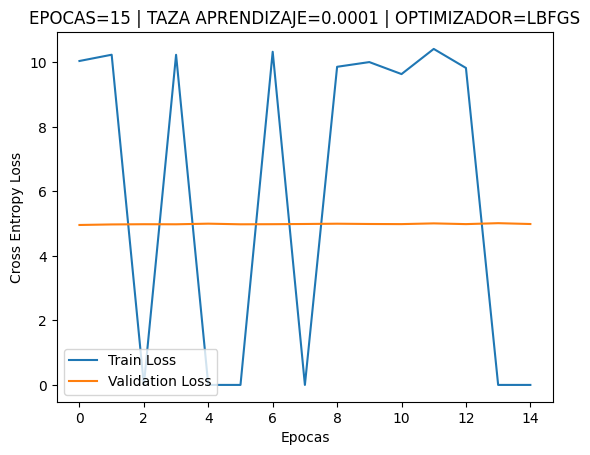

In [103]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  self._circuit.cnot(i, i + 1)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 9.5941
Epoch [1/20]	Validation	Loss: 5.0208	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 9.8381
Epoch [2/20]	Validation	Loss: 5.0167	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.0001
Epoch [3/20]	Validation	Loss: 5.0327	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 0.0000
Epoch [4/20]	Validation	Loss: 5.0059	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 9.8681
Epoch [5/20]	Validation	Loss: 5.0090	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 10.4880
Epoch [6/20]	Validation	Loss: 5.0070	Validation Accuracy: 50.0%
Epoch [7/20]	Training [35%]	Loss: 0.0001
Epoch [7/20]	Validation	Loss: 5.0396	Validation Accuracy: 50.0%
Epoch [8/20]	Training [40%]	Loss: 10.3540
Epoch [8/20]	Validation	Loss: 5.0012	Validation Accuracy: 50.0%
Epoch [9/20]	Training [45%]	Loss: 0.0001
Epoch [9/20]	Validation	Loss: 5.0274	Validation Accuracy: 50.0%
Epoch [10/20]	Training [50%]	Loss: 10.6440
Epoch [10/2

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


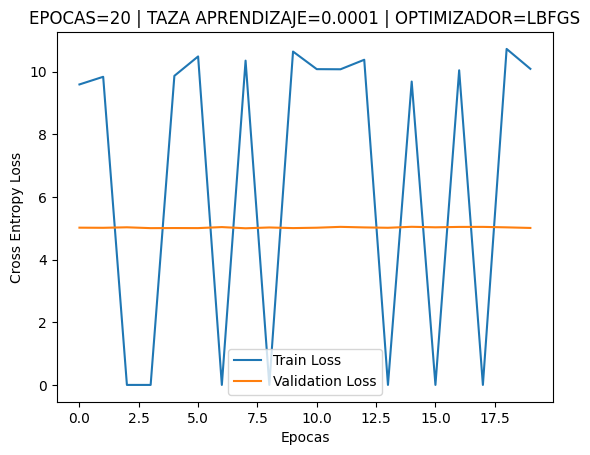

In [104]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

In [105]:
loss.item()

10.010044947182774

Testing the network

In [106]:
"""Use this method directly - """
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Valor real')
    plt.xlabel('Valor predecido')
    plt.tight_layout()

In [107]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

C:\Users\Sergio\AppData\Local\Temp\ipykernel_19316\4126733745.py:38: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Performance on the test data:
	Loss: 5.0165
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)
Confusion matrix, without normalization
[[100   0]
 [100   0]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


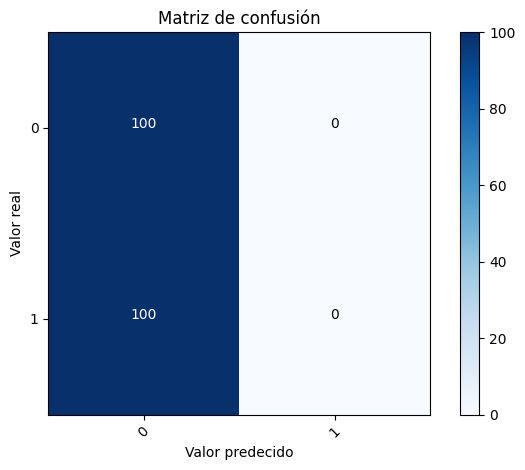

In [108]:
model.eval()

# Lists to store true and predicted labels
y_true = []
y_pred = []

# Lists to store loss values
total_loss = []

# Loop through the test set
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # Forward pass
        output = model(data)

        # Get predicted labels
        pred = output.argmax(dim=1, keepdim=True).view(-1)

        # Save true and predicted labels
        y_true.append(target.item())
        y_pred.append(pred.item())

        # Calculate loss (if needed)
        loss = loss_func(output, target)
        total_loss.append(loss.item())

# Print performance metrics
print('Performance on the test data:\n\tLoss: {:.4f}'.format(sum(total_loss) / len(total_loss)))

precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
# Calculate and print accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
print('\tprecision: {:.1f}%'.format(precision * 100))
print('\trecall: {:.1f}%'.format(recall * 100))
print('\tf_score: {:.1f}%'.format(f_score * 100))
print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
# Create and visualize the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_matrix, [0,1],normalize=False,title='Matriz de confusión',cmap=plt.cm.Blues)


In [109]:
print("acabo")

acabo
